### Imports

In [ ]:
%pip install yfinance
%pip install matplotlib
%pip install scikit-learn
%pip install lxml

In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import requests
import copy
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import math
from tqdm import tqdm
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from lightgbm import LGBMRegressor
from sklearn.model_selection._split import _BaseKFold

## Data collection

In [ ]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}
html = requests.get(url, headers=headers)
SPY_tickers = pd.read_html(html.text)[0]['Symbol'].tolist()
SPY_tickers.append("^GSPC")

In [ ]:
data = yf.download(SPY_tickers, start="2000-01-01", end="2025-11-25", auto_adjust=True)

In [ ]:
data.to_parquet("data/SPY_data.pq")

## Dataset creation

In [2]:
data = pd.read_parquet("data/SPY_data.pq")

In [3]:
# selected_stocks = data['Close'].columns.unique()[(data['Close'].isna().mean()<0.1)]

In [4]:
# len(selected_stocks)

In [3]:
data.columns.get_level_values(0).unique()

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [4]:
log_close = np.log(data['Close'])
log_open  = np.log(data['Open'])
log_high  = np.log(data['High'])
log_low   = np.log(data['Low'])

stocks = data['Close'].columns.unique()[:-1]
# stocks = selected_stocks[:-1]
index = '^GSPC'

# --- returns ---
close_diff = log_close[stocks].diff()
index_ret  = log_close[index].diff()

df = close_diff.mul(1e4).stack().rename("close_1d_ret").reset_index()

df["close_1d_ret_hedged"] = (
    (close_diff.sub(index_ret, axis=0) * 1e4)
    .stack()
    .values
)

# --- open-close ---
open_close = (log_close[stocks] - log_open[stocks]) * 1e4
open_close_idx = (log_close[index] - log_open[index]) * 1e4

df = df.merge(
    open_close.stack().rename("open_close_ret").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    (open_close.sub(open_close_idx, axis=0))
        .stack()
        .rename("open_close_ret_hedged")
        .reset_index(),
    on=["Date", "Ticker"]
)

# --- close-open ---

close_open = (log_open[stocks] - log_close[stocks].shift()) * 1e4
close_open_idx = (log_open[index] - log_close[index].shift()) * 1e4

df = df.merge(
    close_open.stack().rename("close_open_ret").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    (close_open.sub(close_open_idx, axis=0))
        .stack()
        .rename("close_open_ret_hedged")
        .reset_index(),
    on=["Date", "Ticker"]
)

# --- high-low ---
high_low = (log_high[stocks] - log_low[stocks]) * 1e4
high_low_idx = (log_high[index] - log_low[index]) * 1e4

df = df.merge(
    high_low.stack().rename("high_low_ret").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    (high_low.sub(high_low_idx, axis=0))
        .stack()
        .rename("high_low_ret_hedged")
        .reset_index(),
    on=["Date", "Ticker"]
)

# --- volumes ---
volume = data['Volume'][stocks]
dollar_volume = volume * (data['Open'][stocks] + data['Close'][stocks])/2
dolar_volume_share = volume.div(volume.sum(axis=1), axis=0)

df = df.merge(
    volume.stack().rename("volume").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    dollar_volume.stack().rename("dollar_volume").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    dolar_volume_share.stack().rename("share_dollar_volume").reset_index(),
    on=["Date", "Ticker"]
)

In [5]:
df['body_ratio'] = df['open_close_ret'] / (df['high_low_ret']+1e-8)

In [6]:
df['turnover_proxy'] = df['dollar_volume'] / df.groupby('Date')['dollar_volume'].transform('mean')

In [7]:
df['close_1d_ret_normalised'] = df['close_1d_ret']/df.groupby('Date')['close_1d_ret'].transform(lambda x: x.rolling(63).std()*2)

In [8]:
df['close_1d_ret_hedged_normalised'] = df['close_1d_ret_hedged']/df.groupby('Date')['close_1d_ret_hedged'].transform(lambda x: x.rolling(63).std()*2)

In [9]:
df.set_index('Date', inplace=True)

In [10]:
df['close_1d_ret_normalised_lag1'] = df.groupby('Ticker')['close_1d_ret_normalised'].shift()
df['close_1d_ret_hedged_normalised_lag1'] = df.groupby('Ticker')['close_1d_ret_hedged_normalised'].shift()
df['close_1d_ret_lag1'] = df.groupby('Ticker')['close_1d_ret'].shift()
df['close_1d_ret_hedged_lag1'] = df.groupby('Ticker')['close_1d_ret_hedged'].shift()
df['open_close_ret'] = df.groupby('Ticker')['open_close_ret'].shift()
df['open_close_ret_hedged'] = df.groupby('Ticker')['open_close_ret_hedged'].shift()
df['close_open_ret'] = df.groupby('Ticker')['close_open_ret'].shift()
df['close_open_ret_hedged'] = df.groupby('Ticker')['close_open_ret_hedged'].shift()
df['high_low_ret'] = df.groupby('Ticker')['high_low_ret'].shift()
df['high_low_ret_hedged'] = df.groupby('Ticker')['high_low_ret_hedged'].shift()
df['share_dollar_volume'] = df.groupby('Ticker')['share_dollar_volume'].shift()
df['body_ratio'] = df.groupby('Ticker')['body_ratio'].shift()
df['turnover_proxy'] = df.groupby('Ticker')['turnover_proxy'].shift()

In [11]:
df.tail()

Ticker  close_1d_ret  close_1d_ret_hedged  open_close_ret  \
Date                                                                   
2025-11-24    XYZ    -14.538433          -168.026622     -102.779030   
2025-11-24    YUM   -124.977450          -278.465639      205.389469   
2025-11-24    ZBH    144.320589            -9.167600      297.280165   
2025-11-24   ZBRA     62.060605           -91.427584      370.765291   
2025-11-24    ZTS     66.142011           -87.346178      476.520315   

            open_close_ret_hedged  close_open_ret  close_open_ret_hedged  \
Date                                                                       
2025-11-24            -174.549343      102.779030              76.798313   
2025-11-24             133.619155       44.135145              18.154428   
2025-11-24             225.509851       45.926550              19.945833   
2025-11-24             298.994977      164.144503             138.163786   
2025-11-24             404.750001       42.192155              16.211439   

            high_low_ret  high_low_ret_hedged     volume  dollar_volume  \
Date                                                                      
2025-11-24    551.886861           342.305225  7393600.0   4.579411e+08   
2025-11-24    232.154747            22.573111  3656900.0   5.535747e+08   
2025-11-24    398.187759           188.606124  2779100.0   2.587412e+08   
2025-11-24    552.874732           343.293096   930100.0   2.251958e+08   
2025-11-24    533.773332           324.191696  7826900.0   9.568385e+08   

            share_dollar_volume  body_ratio  turnover_proxy  \
Date                                                          
2025-11-24             0.003245   -0.186232        0.731647   
2025-11-24             0.000613    0.884709        0.334742   
2025-11-24             0.000634    0.746583        0.208053   
2025-11-24             0.000284    0.670614        0.243013   
2025-11-24             0.001584    0.892739        0.683883   

            close_1d_ret_normalised  close_1d_ret_hedged_normalised  \
Date                                                                  
2025-11-24                -0.033618                       -0.388543   
2025-11-24                -0.295644                       -0.658732   
2025-11-24                 0.343486                       -0.021819   
2025-11-24                 0.148324                       -0.218510   
2025-11-24                 0.158182                       -0.208893   

            close_1d_ret_normalised_lag1  close_1d_ret_hedged_normalised_lag1  \
Date                                                                            
2025-11-24                      0.000000                            -0.309149   
2025-11-24                      0.811420                             0.493547   
2025-11-24                      1.104578                             0.789975   
2025-11-24                      1.647828                             1.346699   
2025-11-24                      1.543503                             1.252631   

            close_1d_ret_lag1  close_1d_ret_hedged_lag1  
Date                                                     
2025-11-24           0.000000                -97.751030  
2025-11-24         249.524614                151.773584  
2025-11-24         343.206715                245.455684  
2025-11-24         534.909794                437.158763  
2025-11-24         518.712470                420.961440

In [12]:
linear_features = ['close_1d_ret_lag1', 'close_1d_ret_hedged_lag1', 'open_close_ret', 'open_close_ret_hedged', 'close_open_ret', 'close_open_ret_hedged', 'high_low_ret', 'high_low_ret_hedged', 'body_ratio']
non_linear_features = ['share_dollar_volume', 'turnover_proxy']

In [13]:
with open("linear_features.pkl", "wb") as f:
    pkl.dump(linear_features, f)

with open("non_linear_features.pkl", "wb") as f:
    pkl.dump(non_linear_features, f)

In [14]:
df

Ticker  close_1d_ret  close_1d_ret_hedged  open_close_ret  \
Date                                                                   
2000-01-04      A   -794.644473          -403.652719             NaN   
2000-01-04   AAPL   -880.774130          -489.782377             NaN   
2000-01-04    ABT   -289.872231           101.119523             NaN   
2000-01-04   ACGL    -54.500128           336.491626             NaN   
2000-01-04   ADBE   -876.181853          -485.190099             NaN   
...           ...           ...                  ...             ...   
2025-11-24    XYZ    -14.538433          -168.026622     -102.779030   
2025-11-24    YUM   -124.977450          -278.465639      205.389469   
2025-11-24    ZBH    144.320589            -9.167600      297.280165   
2025-11-24   ZBRA     62.060605           -91.427584      370.765291   
2025-11-24    ZTS     66.142011           -87.346178      476.520315   

            open_close_ret_hedged  close_open_ret  close_open_ret_hedged  \
Date                                                                       
2000-01-04                    NaN             NaN                    NaN   
2000-01-04                    NaN             NaN                    NaN   
2000-01-04                    NaN             NaN                    NaN   
2000-01-04                    NaN             NaN                    NaN   
2000-01-04                    NaN             NaN                    NaN   
...                           ...             ...                    ...   
2025-11-24            -174.549343      102.779030              76.798313   
2025-11-24             133.619155       44.135145              18.154428   
2025-11-24             225.509851       45.926550              19.945833   
2025-11-24             298.994977      164.144503             138.163786   
2025-11-24             404.750001       42.192155              16.211439   

            high_low_ret  high_low_ret_hedged       volume  dollar_volume  \
Date                                                                        
2000-01-04           NaN                  NaN    4765083.0   1.917209e+08   
2000-01-04           NaN                  NaN  512377600.0   4.048177e+08   
2000-01-04           NaN                  NaN   10734887.0   8.536908e+07   
2000-01-04           NaN                  NaN      84600.0   1.019541e+05   
2000-01-04           NaN                  NaN    7813200.0   1.193387e+08   
...                  ...                  ...          ...            ...   
2025-11-24    551.886861           342.305225    7393600.0   4.579411e+08   
2025-11-24    232.154747            22.573111    3656900.0   5.535747e+08   
2025-11-24    398.187759           188.606124    2779100.0   2.587412e+08   
2025-11-24    552.874732           343.293096     930100.0   2.251958e+08   
2025-11-24    533.773332           324.191696    7826900.0   9.568385e+08   

            share_dollar_volume  body_ratio  turnover_proxy  \
Date                                                          
2000-01-04                  NaN         NaN             NaN   
2000-01-04                  NaN         NaN             NaN   
2000-01-04                  NaN         NaN             NaN   
2000-01-04                  NaN         NaN             NaN   
2000-01-04                  NaN         NaN             NaN   
...                         ...         ...             ...   
2025-11-24             0.003245   -0.186232        0.731647   
2025-11-24             0.000613    0.884709        0.334742   
2025-11-24             0.000634    0.746583        0.208053   
2025-11-24             0.000284    0.670614        0.243013   
2025-11-24             0.001584    0.892739        0.683883   

            close_1d_ret_normalised  close_1d_ret_hedged_normalised  \
Date                                                                  
2000-01-04                      NaN                             NaN   
2000-01-04                      NaN               

In [15]:
df.to_parquet('df_base.pq')

# Baseline models

## Random Strategy

In [16]:
df = pd.read_parquet('df_base.pq')

In [17]:
np.random.seed(42)
df['random_signal'] = 0.0

def assign_random_signals(group):
    n = len(group)
    if n >= 70:
        signals = np.array([1.0] * 35 + [-1.0] * 35 + [0.0] * (n - 70))
        np.random.shuffle(signals)
        return pd.Series(signals, index=group.index)
    else:
        return pd.Series(0.0, index=group.index)

df['random_signal'] = df.groupby('Date', group_keys=False).apply(assign_random_signals)

In [18]:
random_daily_returns = df.groupby('Date').apply(lambda x: (x['random_signal']*x['close_1d_ret']).sum()/70)

<Axes: title={'center': 'Cumulative Random Strategy Return'}, xlabel='Date'>

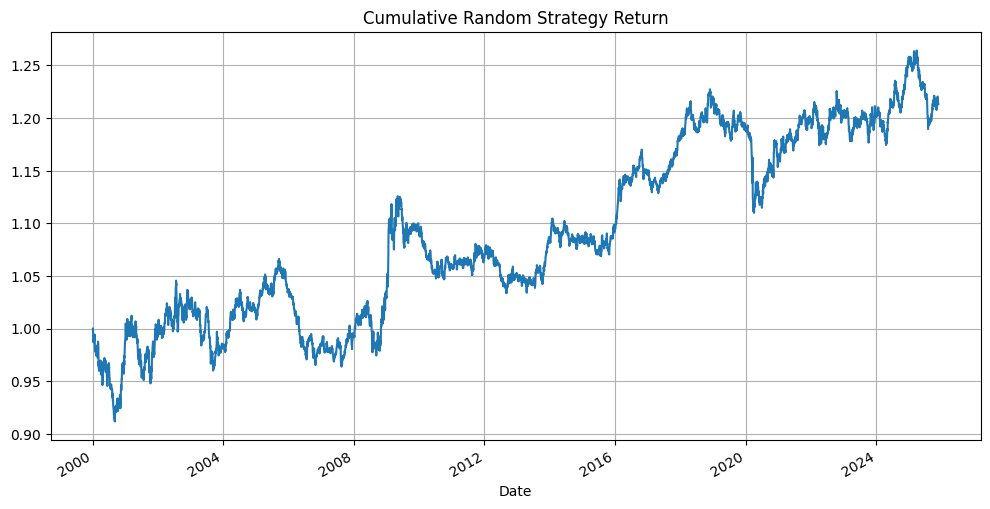

In [19]:
(random_daily_returns*1e-4+1).cumprod().plot(figsize=(12,6), title='Cumulative Random Strategy Return', grid=True)

In [20]:
random_daily_returns.mean()/random_daily_returns.std()*252**0.5

np.float64(0.21580421264586783)

## Momentum Strategies

In [22]:
df = pd.read_parquet('df_base.pq')

### Simple Momentum Strategy

In [13]:
def compute_signal(x):
    if x.notna().sum() == 0:
        return pd.Series([np.nan]*len(x), index=x.index)
    ranks = x.rank(method='first')
    binned = pd.cut(ranks, bins=10, labels=False, include_lowest=True)
    signal = binned.map(lambda y: -1 if y == 0 else (1 if y == 9 else 0))
    return signal

In [24]:
df['momentum_signal'] = df.groupby('Date')['close_1d_ret_hedged_normalised_lag1'].transform(compute_signal)

In [25]:
momentum_daily_returns = df.groupby('Date').apply(
    lambda x: (x['momentum_signal'] * x['close_1d_ret']).sum()/70
)*1e-4

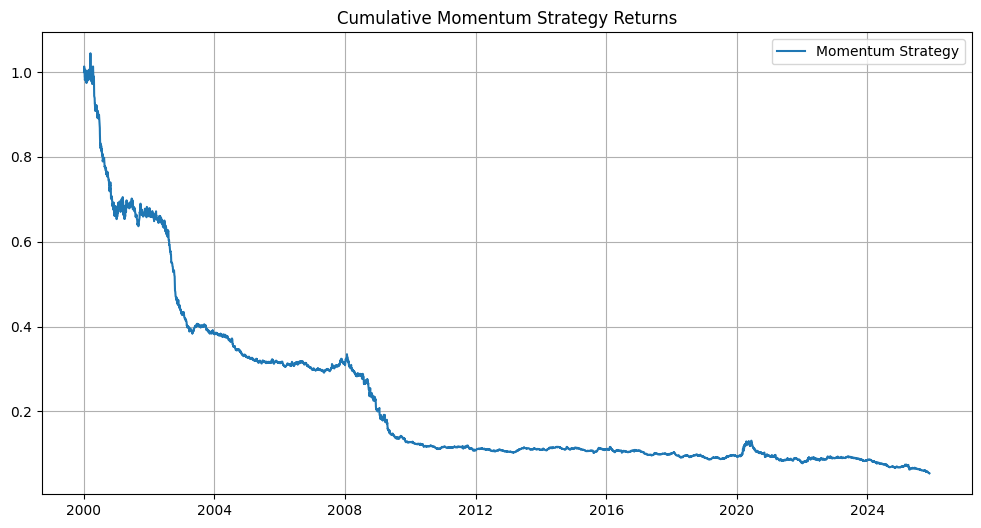

In [26]:
plt.figure(figsize=(12, 6))
plt.plot((momentum_daily_returns+1).cumprod(), label='Momentum Strategy')
plt.title('Cumulative Momentum Strategy Returns')
plt.grid(True)
plt.legend()
plt.show()

In [27]:
momentum_daily_returns.mean()/momentum_daily_returns.std()*np.sqrt(252)

np.float64(-0.9551907858484825)

In [28]:
monthly_returns = np.log(data['Close'].resample('MS').first()).diff().iloc[1:]

In [29]:
monthly_returns_normalised = monthly_returns/(np.log(data['Close']).diff().rolling(21).std()*np.sqrt(12)).resample('MS').first().iloc[1:]

In [30]:
monthly_momentum_rank = monthly_returns_normalised.rank(method='first', axis=1)
monthly_momentum_bin = monthly_momentum_rank.apply(lambda row: pd.cut(row, bins=10, labels=False, include_lowest=True), axis=1)
monthly_momentum_signal = monthly_momentum_bin.map(lambda y: -1 if y == 0 else (1 if y == 9 else 0)).shift()

In [31]:
monthly_momentum_returns = (monthly_momentum_signal*monthly_returns).sum(1)/70

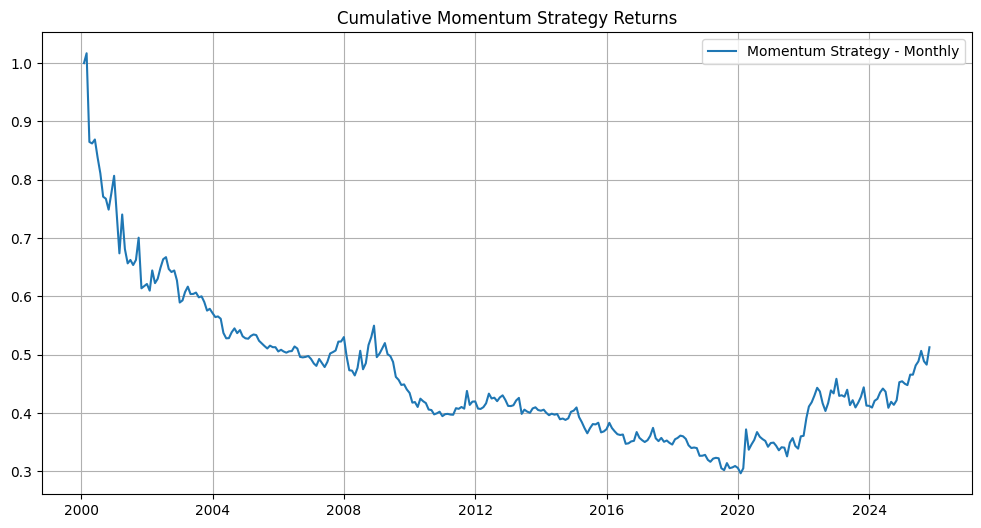

In [32]:
plt.figure(figsize=(12, 6))
plt.plot((monthly_momentum_returns+1).cumprod(), label='Momentum Strategy - Monthly')
plt.title('Cumulative Momentum Strategy Returns')
plt.grid(True)
plt.legend()
plt.show()

In [33]:
monthly_momentum_returns.mean()/monthly_momentum_returns.std()*np.sqrt(252)

np.float64(-0.7749974254793959)

### MACD Vol adjusted Strategy

In [34]:
short_span_list = [8, 16, 32]
long_span_list = [24, 48, 96]

In [35]:
for i, (short_span, long_span) in enumerate(zip(short_span_list, long_span_list)):
    macd_adj_series = (df.groupby('Ticker')['close_1d_ret_hedged_normalised'].ewm(span=short_span, adjust=False).mean() - df.groupby('Ticker')['close_1d_ret_hedged'].ewm(span=long_span, adjust=False).mean())/df.groupby('Ticker')['close_1d_ret_hedged'].rolling(63).std()
    macd_adj_series.name = f'macd_adj_{i+1}'
    df = df.merge(macd_adj_series, on=['Date', 'Ticker'], how='right')
    df[f'macd_adj_{i+1}'] /= df[f'macd_adj_{i+1}'].rolling(252).std()

In [36]:
def phi_baz(x):
    return x / np.sqrt(1 + x**2)

In [37]:
df['macd_baz_signal'] = df[['macd_adj_1', 'macd_adj_2', 'macd_adj_3']].apply(phi_baz).sum(1).replace(0, np.nan)
df['macd_baz_signal'] = df.groupby('Date')['macd_baz_signal'].transform(compute_signal)

In [38]:
df['macd_tanh_signal'] = df[['macd_adj_1', 'macd_adj_2', 'macd_adj_3']].apply(np.tanh).sum(1).replace(0, np.nan)
df['macd_tanh_signal']  = df.groupby('Date')['macd_tanh_signal'].transform(compute_signal)

In [39]:
df['macd_baz_signal'] = df.groupby('Ticker')['macd_baz_signal'].shift()
df['macd_tanh_signal'] = df.groupby('Ticker')['macd_tanh_signal'].shift()

In [40]:
macd_daily_returns = df.groupby('Date').apply(
    lambda x: pd.Series({
        'baz': (x['macd_baz_signal'] * x['close_1d_ret']).sum()/70,
        'tanh': (x['macd_tanh_signal'] * x['close_1d_ret']).sum()/70
    })
)*1e-4

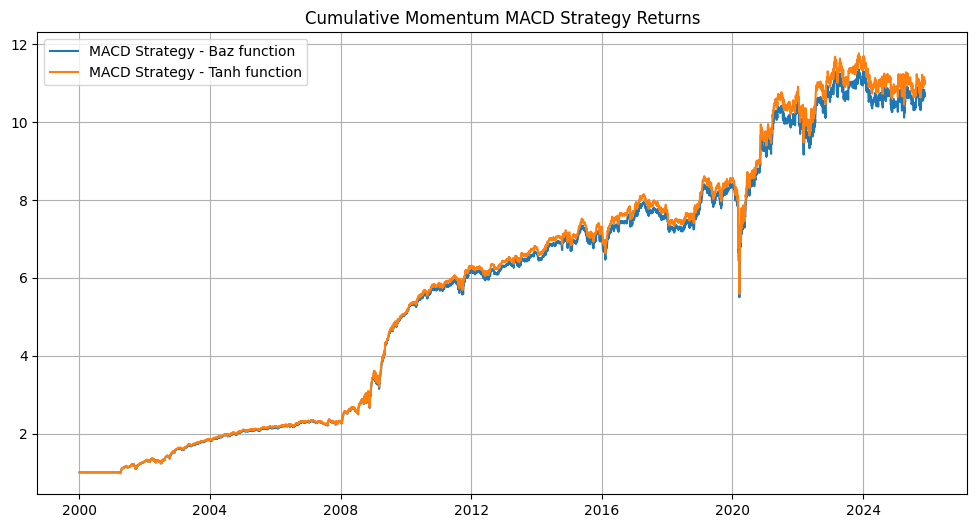

In [41]:
plt.figure(figsize=(12, 6))
plt.plot((macd_daily_returns['baz']+1).cumprod(), label='MACD Strategy - Baz function')
plt.plot((macd_daily_returns['tanh']+1).cumprod(), label='MACD Strategy - Tanh function')

plt.title('Cumulative Momentum MACD Strategy Returns')
plt.grid(True)
plt.legend()
plt.show()

In [42]:
macd_daily_returns.mean()/macd_daily_returns.std()*np.sqrt(252)

baz     0.920004
tanh    0.931652
dtype: float64

# Regress-then-rank Strategies 

In [21]:
df = pd.read_parquet('df_base.pq')

## Linear Regression

### Feature factory

In [22]:
with open("linear_features.pkl", "rb") as f:
    linear_features = pkl.load(f)

In [23]:
all_linear_features = copy.deepcopy(linear_features)

In [24]:
for feature in tqdm(linear_features):
    for h in [3, 5, 10, 15, 20, 30, 60, 80]:
        df[f'avg_{feature}_{h}d'] = df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).mean())
        df[f'zscore_{feature}_{h}d'] = (df[feature]-df[f'avg_{feature}_{h}d'])/df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).std())
        df[f'sharpe_{feature}_{h}d'] = df[f'avg_{feature}_{h}d']/df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).std())
        all_linear_features.append(f'avg_{feature}_{h}d')
        all_linear_features.append(f'zscore_{feature}_{h}d')
        all_linear_features.append(f'sharpe_{feature}_{h}d')

  0%|          | 0/9 [00:00<?, ?it/s]

 44%|████▍     | 4/9 [00:36<00:44,  8.86s/it]/tmp/ipykernel_283567/3641886625.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'sharpe_{feature}_{h}d'] = df[f'avg_{feature}_{h}d']/df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).std())
/tmp/ipykernel_283567/3641886625.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'avg_{feature}_{h}d'] = df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).mean())
/tmp/ipykernel_283567/3641886625.py:4: PerformanceWarning: DataFrame is highly fragmented.  T

In [25]:
df.to_parquet('df_all_linear_features.pq')

In [26]:
with open("all_linear_features.pkl", "wb") as f:
    pkl.dump(all_linear_features, f)

### Article features

In [203]:
df = pd.read_parquet('df_base.pq')

In [204]:
article_features = []

feature = 'close_1d_ret'
for h in [3, 5, 20, 60]:
    df[f'avg_{feature}_{h}d'] = df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).mean())
    df[f'avg_{feature}_{h}d'] = df.groupby('Ticker')[f'avg_{feature}_{h}d'].shift()
    df[f'vol_{h}d'] = df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).std())*np.sqrt(252)
    df[f'vol_{h}d'] = df.groupby('Ticker')[f'vol_{h}d'].shift()
    df[f'avg_normalised_{feature}_{h}d'] = df[f'avg_{feature}_{h}d']/df[f'vol_{h}d']
    article_features.append(f'avg_{feature}_{h}d')
    article_features.append(f'avg_normalised_{feature}_{h}d')

#### Test for MACD Features

In [67]:
test_df = df[['Ticker']]
short_span_list = [8, 16, 32]
long_span_list = [24, 48, 96]
for window in tqdm([21, 63, 126, 252]):
    for i, (short_span, long_span) in enumerate(zip(short_span_list, long_span_list)):
        macd_adj_series = (df.groupby('Ticker')['close_1d_ret'].ewm(span=short_span, adjust=False).mean() - df.groupby('Ticker')['close_1d_ret'].ewm(span=long_span, adjust=False).mean())/df.groupby('Ticker')['close_1d_ret'].rolling(63).std()
        macd_adj_series.name = f'macd_adj_first_{window}_{i+1}'
        test_df = test_df.merge(macd_adj_series, on=['Date', 'Ticker'], how='right')
        test_df[f'macd_adj_first_{window}_{i+1}'] /= test_df[f'macd_adj_first_{window}_{i+1}'].rolling(window).std()

for window in tqdm([21, 63, 126, 252]):
    for i, (short_span, long_span) in enumerate(zip(short_span_list, long_span_list)):
        macd_adj_series = (df.groupby('Ticker')['close_1d_ret'].ewm(span=short_span, adjust=False).mean() - df.groupby('Ticker')['close_1d_ret'].ewm(span=long_span, adjust=False).mean())/df.groupby('Ticker')['close_1d_ret'].rolling(window).std()
        macd_adj_series.name = f'macd_adj_second_{window}_{i+1}'
        test_df = test_df.merge(macd_adj_series, on=['Date', 'Ticker'], how='right')
        test_df[f'macd_adj_second_{window}_{i+1}'] /= test_df[f'macd_adj_second_{window}_{i+1}'].rolling(252).std()

100%|██████████| 4/4 [00:22<00:00,  5.62s/it]


In [68]:
test_df.drop(columns='Ticker').corr()

macd_adj_first_21_1  macd_adj_first_21_2  \
macd_adj_first_21_1               1.000000             0.861620   
macd_adj_first_21_2               0.861620             1.000000   
macd_adj_first_21_3               0.540281             0.818506   
macd_adj_first_63_1               0.959881             0.820366   
macd_adj_first_63_2               0.848082             0.941084   
macd_adj_first_63_3               0.595314             0.835528   
macd_adj_first_126_1              0.951320             0.812807   
macd_adj_first_126_2              0.837206             0.933320   
macd_adj_first_126_3              0.585213             0.836716   
macd_adj_first_252_1              0.949353             0.811021   
macd_adj_first_252_2              0.833026             0.931987   
macd_adj_first_252_3              0.574956             0.833341   
macd_adj_second_21_1              0.980338             0.839123   
macd_adj_second_21_2              0.851199             0.961110   
macd_adj_second_21_3              0.578902             0.851447   
macd_adj_second_63_1              0.949353             0.811021   
macd_adj_second_63_2              0.833026             0.931987   
macd_adj_second_63_3              0.574956             0.833341   
macd_adj_second_126_1             0.927433             0.792478   
macd_adj_second_126_2             0.814070             0.910901   
macd_adj_second_126_3             0.563714             0.816490   
macd_adj_second_252_1             0.910140             0.777945   
macd_adj_second_252_2             0.799369             0.894606   
macd_adj_second_252_3             0.554106             0.802449   

                       macd_adj_first_21_3  macd_adj_first_63_1  \
macd_adj_first_21_1               0.540281             0.959881   
macd_adj_first_21_2               0.818506             0.820366   
macd_adj_first_21_3               1.000000             0.524526   
macd_adj_first_63_1               0.524526             1.000000   
macd_adj_first_63_2               0.765399             0.878583   
macd_adj_first_63_3               0.913384             0.612412   
macd_adj_first_126_1              0.521727             0.987690   
macd_adj_first_126_2              0.759279             0.862282   
macd_adj_first_126_3              0.905968             0.597993   
macd_adj_first_252_1              0.519830             0.984154   
macd_adj_first_252_2              0.758070             0.855436   
macd_adj_first_252_3              0.908883             0.585218   
macd_adj_second_21_1              0.534527             0.966179   
macd_adj_second_21_2              0.780208             0.829616   
macd_adj_second_21_3              0.937482             0.559451   
macd_adj_second_63_1              0.519830             0.984154   
macd_adj_second_63_2              0.758070             0.855436   
macd_adj_second_63_3              0.908883             0.585218   
macd_adj_second_126_1             0.508127             0.953077   
macd_adj_second_126_2             0.741039             0.828737   
macd_adj_second_126_3             0.887973             0.568899   
macd_adj_second_252_1             0.498989             0.933916   
macd_adj_second_252_2             0.728361             0.812669   
macd_adj_second_252_3             0.873134             0.558567   

                       macd_adj_first_63_2  macd_adj_first_63_3  \
macd_adj_first_21_1               0.848082             0.595314   
macd_adj_first_21_2               0.941084             0.835528   
macd_adj_first_21_3               0.765399             0.913384   
macd_adj_first_63_1               0.878583             0.612412   
macd_adj_first_63_2               1.000000             0.872722   
macd_adj_first_63_3               0.872722             1.000000   
macd_adj_first_126_1              0.868569             0.608132   
macd_adj_first_126_2              0.983968             0.861677   
macd_adj_first_126_3              0.862759             0.973695   
m

#### End

In [205]:
short_span_list = [8, 16, 32]
long_span_list = [24, 48, 96]

for i, (short_span, long_span) in enumerate(zip(short_span_list, long_span_list)):
    macd_adj_series = (df.groupby('Ticker')['close_1d_ret'].ewm(span=short_span, adjust=False).mean() - df.groupby('Ticker')['close_1d_ret'].ewm(span=long_span, adjust=False).mean())/df.groupby('Ticker')['close_1d_ret'].rolling(63).std()
    macd_adj_series.name = f'macd_adj_{i+1}'
    df = df.merge(macd_adj_series, on=['Date', 'Ticker'], how='right')
    df[f'macd_adj_{i+1}'] /= df[f'macd_adj_{i+1}'].rolling(252).std()
    df[f'macd_adj_{i+1}'] = df.groupby('Ticker')[f'macd_adj_{i+1}'].shift()
    article_features.append(f'macd_adj_{i+1}')

In [206]:
def phi_baz(x):
    return x / np.sqrt(1 + x**2)

In [207]:
df['macd_baz_signal'] = df[['macd_adj_1', 'macd_adj_2', 'macd_adj_3']].apply(phi_baz).sum(1).replace(0, np.nan)
article_features.append('macd_baz_signal')

In [208]:
df[article_features].corr()

avg_close_1d_ret_3d  \
avg_close_1d_ret_3d                         1.000000   
avg_normalised_close_1d_ret_3d              0.114855   
avg_close_1d_ret_5d                         0.765642   
avg_normalised_close_1d_ret_5d              0.545281   
avg_close_1d_ret_20d                        0.383271   
avg_normalised_close_1d_ret_20d             0.318139   
avg_close_1d_ret_60d                        0.213141   
avg_normalised_close_1d_ret_60d             0.191705   
macd_adj_1                                  0.739663   
macd_adj_2                                  0.667016   
macd_adj_3                                  0.538634   
macd_baz_signal                             0.662393   

                                 avg_normalised_close_1d_ret_3d  \
avg_close_1d_ret_3d                                    0.114855   
avg_normalised_close_1d_ret_3d                         1.000000   
avg_close_1d_ret_5d                                    0.087811   
avg_normalised_close_1d_ret_5d                         0.130676   
avg_close_1d_ret_20d                                   0.043803   
avg_normalised_close_1d_ret_20d                        0.055418   
avg_close_1d_ret_60d                                   0.026496   
avg_normalised_close_1d_ret_60d                        0.032584   
macd_adj_1                                             0.117263   
macd_adj_2                                             0.105266   
macd_adj_3                                             0.084453   
macd_baz_signal                                        0.112880   

                                 avg_close_1d_ret_5d  \
avg_close_1d_ret_3d                         0.765642   
avg_normalised_close_1d_ret_3d              0.087811   
avg_close_1d_ret_5d                         1.000000   
avg_normalised_close_1d_ret_5d              0.711500   
avg_close_1d_ret_20d                        0.494627   
avg_normalised_close_1d_ret_20d             0.407786   
avg_close_1d_ret_60d                        0.274889   
avg_normalised_close_1d_ret_60d             0.245921   
macd_adj_1                                  0.694607   
macd_adj_2                                  0.728273   
macd_adj_3                                  0.635699   
macd_baz_signal                             0.711281   

                                 avg_normalised_close_1d_ret_5d  \
avg_close_1d_ret_3d                                    0.545281   
avg_normalised_close_1d_ret_3d                         0.130676   
avg_close_1d_ret_5d                                    0.711500   
avg_normalised_close_1d_ret_5d                         1.000000   
avg_close_1d_ret_20d                                   0.348050   
avg_normalised_close_1d_ret_20d                        0.436181   
avg_close_1d_ret_60d                                   0.205395   
avg_normalised_close_1d_ret_60d                        0.254342   
macd_adj_1                                             0.689502   
macd_adj_2                                             0.719935   
macd_adj_3                                             0.626121   
macd_baz_signal                                        0.749243   

                                 avg_close_1d_ret_20d  \
avg_close_1d_ret_3d                          0.383271   
avg_normalised_close_1d_ret_3d               0.043803   
avg_close_1d_ret_5d                          0.494627   
avg_normalised_close_1d_ret_5d               0.348050   
avg_close_1d_ret_20d                         1.000000   
avg_normalised_close_1d_ret_20d              0.811977   
avg_close_1d_ret_60d                         0.557069   
avg_normalised_close_1d_ret_60d              0.480466   
macd_adj_1                                   0.185606   
macd_adj_2                                   0.464135   
macd_adj_3                                   0.678393   
macd_baz_signal                              0.464480   

                                 avg_normalised_close_1d_ret_20d  \
avg_close_1d_ret_3d  

In [209]:
class Winsorizer(BaseEstimator, TransformerMixin):
    """
    Transformateur pour winsoriser les features.
    Les limites sont apprises sur le train set et appliquées au test set.
    """
    def __init__(self, lower=0.01, upper=0.01):
        self.lower = lower
        self.upper = upper
        self.lower_bounds_ = None
        self.upper_bounds_ = None
    
    def fit(self, X, y=None):
        """Apprend les limites de winsorisation sur X"""
        if isinstance(X, pd.DataFrame):
            self.lower_bounds_ = X.quantile(self.lower)
            self.upper_bounds_ = X.quantile(1 - self.upper)
            self.feature_names_ = X.columns
        else:
            # Pour numpy array
            self.lower_bounds_ = np.percentile(X, self.lower * 100, axis=0)
            self.upper_bounds_ = np.percentile(X, (1 - self.upper) * 100, axis=0)
        
        return self
    
    def transform(self, X):
        """Applique la winsorisation avec les limites apprises"""
        if self.lower_bounds_ is None or self.upper_bounds_ is None:
            raise ValueError("Winsorizer must be fitted before transform")
        
        X_copy = X.copy()
        
        if isinstance(X, pd.DataFrame):
            for col in X.columns:
                X_copy[col] = np.clip(X_copy[col], 
                                     self.lower_bounds_[col], 
                                     self.upper_bounds_[col])
        else:
            # Pour numpy array
            X_copy = np.clip(X_copy, self.lower_bounds_, self.upper_bounds_)
        
        return X_copy

In [210]:
X = df[article_features + ["close_1d_ret_hedged_normalised"]].replace([-np.inf, np.inf], np.nan).dropna()[article_features]
y = df[article_features + ["close_1d_ret_hedged_normalised"]].replace([-np.inf, np.inf], np.nan).dropna()["close_1d_ret_hedged_normalised"]

split_date = X.index.unique().sort_values()[int(X.index.nunique()*0.8)]

X_train = X.loc[X.index<split_date]
X_test = X.loc[X.index>=split_date]
y_train = y.loc[y.index<split_date]
y_test = y.loc[y.index>=split_date]

In [212]:
ols_baseline = Pipeline([
    ('winsorizer', Winsorizer(lower=0.001, upper=0.001)),
    ('reg', LinearRegression(fit_intercept=False))
])

In [213]:
ols_baseline.fit(X_train, y_train)

Pipeline(steps=[('winsorizer', Winsorizer(lower=0.001, upper=0.001)),
                ('reg', LinearRegression(fit_intercept=False))])

In [214]:
X_train.columns

Index(['avg_close_1d_ret_3d', 'avg_normalised_close_1d_ret_3d',
       'avg_close_1d_ret_5d', 'avg_normalised_close_1d_ret_5d',
       'avg_close_1d_ret_20d', 'avg_normalised_close_1d_ret_20d',
       'avg_close_1d_ret_60d', 'avg_normalised_close_1d_ret_60d', 'macd_adj_1',
       'macd_adj_2', 'macd_adj_3', 'macd_baz_signal'],
      dtype='object')

In [215]:
ols_baseline.named_steps['reg'].coef_

array([-4.63714541e-05, -3.41430172e-02, -5.40794281e-05, -5.80042804e-02,
        1.27906331e-04,  2.72847294e-02, -2.95791761e-04,  1.22335421e+00,
        6.51337770e-03, -4.61828836e-03, -1.18936583e-02,  7.69606100e-03])

In [216]:
y_pred = ols_baseline.predict(X_test)

In [217]:
X_test.index.min()

Timestamp('2020-12-17 00:00:00')

In [218]:
y_pred.shape

(529033,)

In [219]:
df_test = df[df.index>=split_date][article_features + ["Ticker", "close_1d_ret", "close_1d_ret_hedged_normalised"]].replace([-np.inf, np.inf], np.nan).dropna()[["Ticker", "close_1d_ret", "close_1d_ret_hedged_normalised"]]
# df_test = df[df.index>=split_date].replace([-np.inf, np.inf], np.nan).dropna()

In [220]:
df_test['y_pred'] = y_pred

In [14]:
def compute_signal(x):
    if x.notna().sum() == 0:
        return pd.Series([np.nan]*len(x), index=x.index)
    ranks = x.rank(method='first')
    binned = pd.cut(ranks, bins=10, labels=False, include_lowest=True)
    signal = binned.map(lambda y: -1 if y == 0 else (1 if y == 9 else 0))
    return signal

In [222]:
df_test['ols_signal'] = df_test.groupby('Date')['y_pred'].transform(compute_signal)

In [223]:
ols_daily_returns = df_test.groupby('Date').apply(lambda x: (x['ols_signal']*x['close_1d_ret']).sum()/70)

<Axes: title={'center': 'Cumulative OLS Baseline Strategy Return'}, xlabel='Date'>

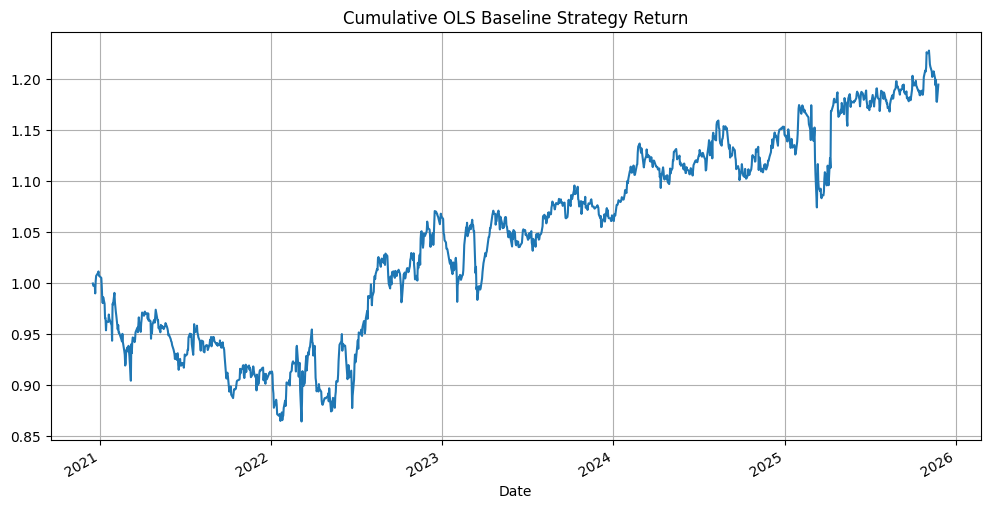

In [224]:
(ols_daily_returns*1e-4+1).cumprod().plot(figsize=(12,6), title='Cumulative OLS Baseline Strategy Return', grid=True)

In [225]:
ols_daily_returns.mean()/ols_daily_returns.std()*np.sqrt(252)

np.float64(0.3714211960797244)

### All features

In [27]:
with open("all_linear_features.pkl", "rb") as f:
    all_linear_features = pkl.load(f)

In [28]:
df = pd.read_parquet('df_all_linear_features.pq')

In [230]:
X = df[all_linear_features + ["close_1d_ret_hedged_normalised"]].replace([-np.inf, np.inf], np.nan).dropna()[all_linear_features]
y = df[all_linear_features + ["close_1d_ret_hedged_normalised"]].replace([-np.inf, np.inf], np.nan).dropna()["close_1d_ret_hedged_normalised"]

split_date = X.index.unique().sort_values()[int(X.index.nunique()*0.8)]

X_train = X.loc[X.index<split_date]
X_test = X.loc[X.index>=split_date]
y_train = y.loc[y.index<split_date]
y_test = y.loc[y.index>=split_date]

In [231]:
ols_baseline.fit(X_train.to_numpy(), y_train)


Pipeline(steps=[('winsorizer', Winsorizer(lower=0.001, upper=0.001)),
                ('reg', LinearRegression(fit_intercept=False))])

In [232]:
y_pred = ols_baseline.predict(X_test.to_numpy())
df_test = df[df.index>=split_date][all_linear_features + ["Ticker", "close_1d_ret", "close_1d_ret_hedged_normalised"]].replace([-np.inf, np.inf], np.nan).dropna()[["Ticker", "close_1d_ret", "close_1d_ret_hedged_normalised"]]
df_test['y_pred'] = y_pred

In [233]:
df_test['ols_signal'] = df_test.groupby('Date')['y_pred'].transform(compute_signal)
ols_daily_returns = df_test.groupby('Date').apply(lambda x: (x['ols_signal']*x['close_1d_ret']).sum()/70)

<Axes: title={'center': 'Cumulative OLS all features Strategy Return'}, xlabel='Date'>

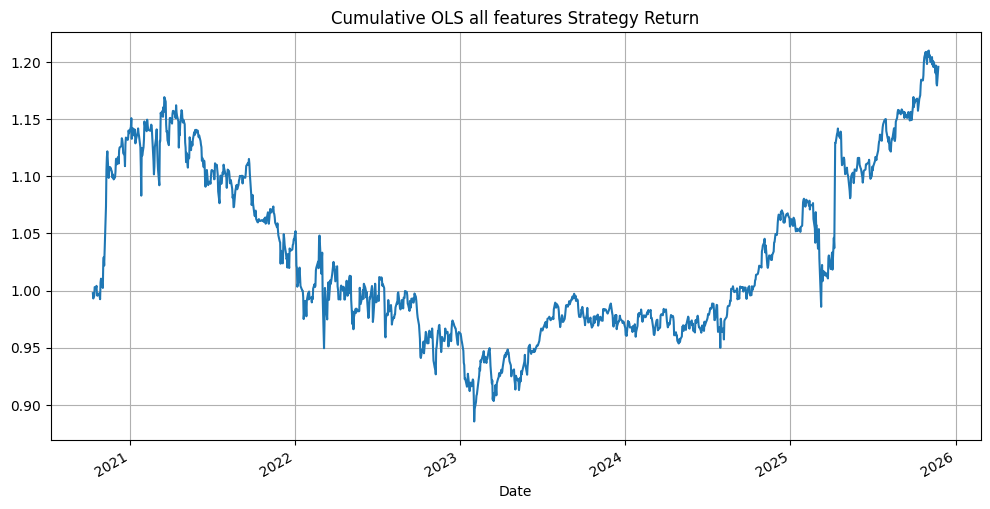

In [234]:
(ols_daily_returns*1e-4+1).cumprod().plot(figsize=(12,6), title='Cumulative OLS all features Strategy Return', grid=True)

In [236]:
ols_daily_returns.mean()/ols_daily_returns.std()*np.sqrt(252)

np.float64(0.3556156897432818)

In [238]:
ols_pca = Pipeline([
    ('winsorizer', Winsorizer(lower=0.001, upper=0.001)),
    ('pca', PCA(n_components=0.95)),
    ('reg', LinearRegression(fit_intercept=False))
])

In [239]:
ols_pca.fit(X_train.to_numpy(), y_train)
y_pred_pca = ols_pca.predict(X_test.to_numpy())
df_test = df[df.index>=split_date][all_linear_features + ["Ticker", "close_1d_ret", "close_1d_ret_hedged_normalised"]].replace([-np.inf, np.inf], np.nan).dropna()[["Ticker", "close_1d_ret", "close_1d_ret_hedged_normalised"]]
df_test['y_pred'] = y_pred_pca
df_test['ols_signal'] = df_test.groupby('Date')['y_pred'].transform(compute_signal)
ols_pca_daily_returns = df_test.groupby('Date').apply(lambda x: (x['ols_signal']*x['close_1d_ret']).sum()/70)

<Axes: title={'center': 'Cumulative OLS + PCA Strategy Return'}, xlabel='Date'>

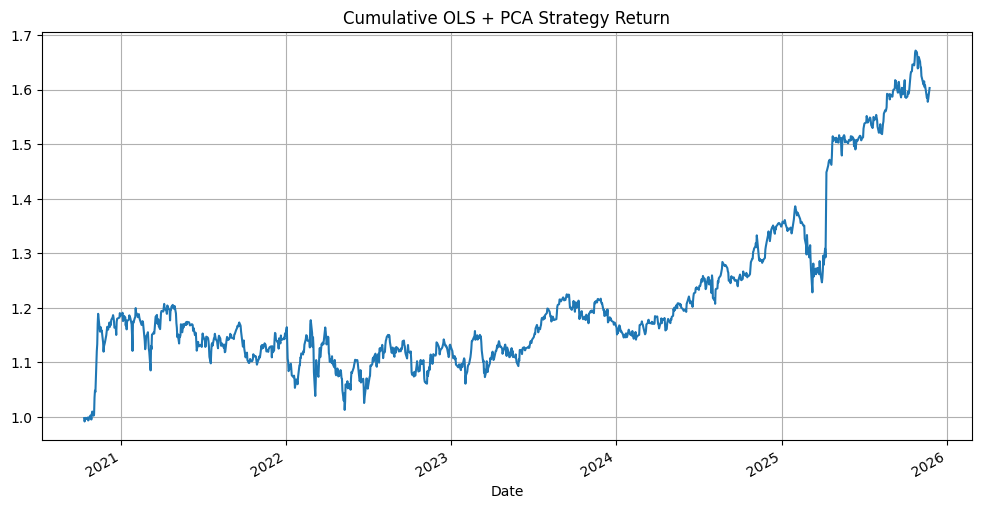

In [240]:
(ols_pca_daily_returns*1e-4+1).cumprod().plot(figsize=(12,6), title='Cumulative OLS + PCA Strategy Return', grid=True)

In [241]:
ols_pca_daily_returns.mean()/ols_pca_daily_returns.std()*np.sqrt(252)

np.float64(0.7130837681836139)

## LGBM Regressor

#### Non linear features

In [ ]:
df = pd.read_parquet('df_all_linear_features.pq')

In [30]:
with open("all_linear_features.pkl", "rb") as f:
    all_linear_features = pkl.load(f)
    
with open("non_linear_features.pkl", "rb") as f:
    non_linear_features = pkl.load(f)

In [31]:
all_features = all_linear_features + non_linear_features

In [32]:
for window in tqdm([5, 10, 21, 42, 63, 126, 252]):
    df[f'vol_{window}d'] = df.groupby('Ticker')['close_1d_ret'].transform(lambda x: x.rolling(window).std().shift())
    df[f'kurt_{window}d'] = df.groupby('Ticker')['close_1d_ret'].transform(lambda x: x.rolling(window).kurt().shift())
    df[f'skew_{window}d'] = df.groupby('Ticker')['close_1d_ret'].transform(lambda x: x.rolling(window).skew().shift())
    all_features.append(f'vol_{window}d')
    all_features.append(f'kurt_{window}d')
    all_features.append(f'skew_{window}d')
    if window>=10:
        df[f'vol_upside_{window}d'] = df.groupby('Ticker')['close_1d_ret'].transform(lambda x: x.where(x>0, 0).rolling(window).std().shift())
        df[f'vol_downside_{window}d'] = df.groupby('Ticker')['close_1d_ret'].transform(lambda x: x.where(x<0, 0).rolling(window).std().shift())
        all_features.append(f'vol_upside_{window}d')
        all_features.append(f'vol_downside_{window}d')

100%|██████████| 7/7 [00:15<00:00,  2.15s/it]


In [38]:
df.to_parquet('df_all_features.pq')

In [33]:
with open("all_features.pkl", "wb") as f:
    pkl.dump(all_features, f)

#### End

In [2]:
df = pd.read_parquet('df_all_features.pq')

In [3]:
with open("all_features.pkl", "rb") as f:
    all_features = pkl.load(f)

In [4]:
len(all_features)

260

In [6]:
X = df[all_features + ["close_1d_ret_hedged_normalised"]].replace([-np.inf, np.inf], np.nan).dropna()[all_features]
y = df[all_features + ["close_1d_ret_hedged_normalised"]].replace([-np.inf, np.inf], np.nan).dropna()["close_1d_ret_hedged_normalised"]

split_date = X.index.unique().sort_values()[int(X.index.nunique()*0.8)]

X_train = X.loc[X.index<split_date]
X_test = X.loc[X.index>=split_date]
y_train = y.loc[y.index<split_date]
y_test = y.loc[y.index>=split_date]

In [7]:
lgbm = Pipeline([
    # ('scaler', StandardScaler()),
    # ('pca', PCA(n_components=0.95)),
    ('model', LGBMRegressor(
        objective="regression",
        boosting_type="gbdt",
        random_state=42,
        n_jobs=-1,
        force_col_wise=True 
    ))
])

In [8]:
%%time 
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 66300
[LightGBM] [Info] Number of data points in the train set: 1779489, number of used features: 260
[LightGBM] [Info] Start training from score 0.007649
CPU times: user 2min 52s, sys: 862 ms, total: 2min 52s
Wall time: 7.97 s


Pipeline(steps=[('model',
                 LGBMRegressor(force_col_wise=True, n_jobs=-1,
                               objective='regression', random_state=42))])

In [9]:
y_pred_lgbm = lgbm.predict(X_test)

In [10]:
df_test = df[df.index>=split_date][all_features + ["Ticker", "close_1d_ret", "close_1d_ret_hedged_normalised"]].replace([-np.inf, np.inf], np.nan).dropna()[["Ticker", "close_1d_ret", "close_1d_ret_hedged_normalised"]]

In [11]:
df_test['y_pred'] = y_pred_lgbm

In [15]:
df_test['lgbm_signal'] = df_test.groupby('Date')['y_pred'].transform(compute_signal)
lgbm_daily_returns = df_test.groupby('Date').apply(lambda x: (x['lgbm_signal']*x['close_1d_ret']).sum()/70)

<Axes: title={'center': 'Cumulative LGBM Strategy Return'}, xlabel='Date'>

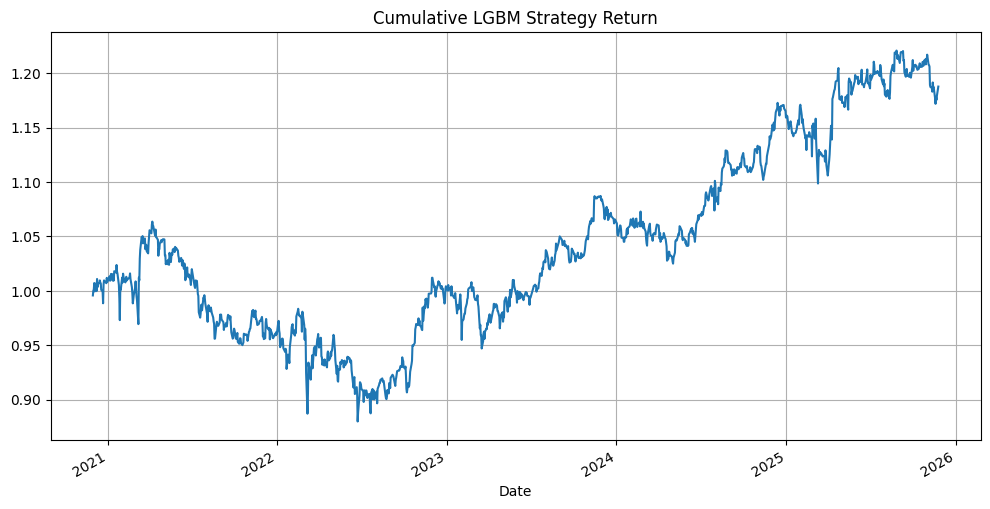

In [16]:
(lgbm_daily_returns*1e-4+1).cumprod().plot(figsize=(12,6), title='Cumulative LGBM Strategy Return', grid=True)

In [17]:
lgbm_daily_returns.mean()/lgbm_daily_returns.std()*np.sqrt(252)

np.float64(0.38752257255002753)

In [18]:
class ExpandingWindowCV(_BaseKFold):
    """
    Expanding Window Cross-Validator with fixed test size based on unique dates.
    
    This cross-validator creates splits where:
    - Split 1: Train on first 50% of unique dates, test on next 15% of unique dates
    - Split 2: Train on first 65% of unique dates, test on next 15% of unique dates
    - Split 3: Train on first 85% of unique dates, test on last 15% of unique dates
    
    The DataFrame is expected to be indexed by dates, with potentially multiple rows per date.
    The split is performed on unique dates, and all rows corresponding to dates in the 
    train/test periods are included in the respective sets.
    
    Parameters
    ----------
    n_splits : int, default=3
        Number of folds (fixed at 3 for this implementation)
    """
    
    def __init__(self, n_splits=3):
        super().__init__(n_splits=n_splits, shuffle=False, random_state=None)
        if n_splits != 3:
            raise ValueError("This implementation is designed for exactly 3 splits")
    
    def split(self, X, y=None, groups=None):
        """
        Generate indices to split data into training and test set based on unique dates.
        
        Parameters
        ----------
        X : pandas DataFrame with DatetimeIndex
            Training data indexed by dates
        y : array-like of shape (n_samples,), default=None
            Target variable
        groups : array-like of shape (n_samples,), default=None
            Group labels (not used)
            
        Yields
        ------
        train : ndarray
            The training set indices for that split
        test : ndarray
            The testing set indices for that split
        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a pandas DataFrame with DatetimeIndex")
        
        if not isinstance(X.index, pd.DatetimeIndex):
            raise TypeError("X must have a DatetimeIndex")
        
        # Get unique dates and sort them
        unique_dates = pd.Series(X.index.unique()).sort_values().values
        n_unique_dates = len(unique_dates)
        
        # Define train/test boundaries as percentages of unique dates
        splits_config = [
            (0.50, 0.65),  # Train: 0-50%, Test: 50-65%
            (0.65, 0.80),  # Train: 0-65%, Test: 65-80%
            (0.85, 1.00),  # Train: 0-85%, Test: 85-100%
        ]
        
        for train_end_pct, test_end_pct in splits_config:
            train_end_idx = int(np.floor(train_end_pct * n_unique_dates))
            test_end_idx = int(np.floor(test_end_pct * n_unique_dates))
            
            # Get the date boundaries
            train_dates = unique_dates[:train_end_idx]
            test_dates = unique_dates[train_end_idx:test_end_idx]
            
            # Get all row indices corresponding to these dates
            train_indices = np.where(X.index.isin(train_dates))[0]
            test_indices = np.where(X.index.isin(test_dates))[0]
            
            yield train_indices, test_indices
    
    def get_n_splits(self, X=None, y=None, groups=None):
        """Returns the number of splitting iterations in the cross-validator"""
        return self.n_splits

In [19]:
cv = ExpandingWindowCV(n_splits=3)

In [ ]:
param_distributions = {
    'model__num_leaves': [20, 31, 50, 75],
    'model__learning_rate': [0.005, 0.01, 0.03],
    'model__n_estimators': [100, 200, 300, 500],

    'model__min_child_samples': [50, 100, 150, 200, 500],
    'model__min_child_weight': [0.01, 0.1, 1],
    'model__reg_alpha': [0.1, 1, 5, 10],
    'model__reg_lambda': [0.1, 1, 5, 10],

    'model__subsample': [0.7, 0.8, 0.85],
    'model__subsample_freq': [1],
    'model__colsample_bytree': [0.7, 0.8, 0.85],

    'model__max_depth': [5, 7, 9],
}

In [21]:
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_distributions,
    n_iter=100,
    scoring="neg_mean_squared_error",
    cv=cv,
    n_jobs=1,
    verbose=1,
    random_state=42
)

In [22]:
%%time
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[LightGBM] [Info] Total Bins 66300
[LightGBM] [Info] Number of data points in the train set: 802537, number of used features: 260
[LightGBM] [Info] Start training from score 0.010611
[LightGBM] [Info] Total Bins 66300
[LightGBM] [Info] Number of data points in the train set: 1078492, number of used features: 260
[LightGBM] [Info] Start training from score 0.009381
[LightGBM] [Info] Total Bins 66300
[LightGBM] [Info] Number of data points in the train set: 1471273, number of used features: 260
[LightGBM] [Info] Start training from score 0.009066
[LightGBM] [Info] Total Bins 66300
[LightGBM] [Info] Number of data points in the train set: 802537, number of used features: 260
[LightGBM] [Info] Start training from score 0.010611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

RandomizedSearchCV(cv=ExpandingWindowCV(n_splits=3),
                   estimator=Pipeline(steps=[('model',
                                              LGBMRegressor(force_col_wise=True,
                                                            n_jobs=-1,
                                                            objective='regression',
                                                            random_state=42))]),
                   n_iter=100, n_jobs=1,
                   param_distributions={'model__colsample_bytree': [0.7, 0.8,
                                                                    0.85],
                                        'model__learning_rate': [0.005, 0.01,
                                                                 0.03],
                                        'model__max_depth': [5, 7, 9],
                                        'model__min_child_samples': [50, 100,
                                                                     150, 200,
                                                                     500],
                                        'model__min_child_weight': [0.01, 0.1,
                                                                    1],
                                        'model__n_estimators': [100, 200, 300,
                                                                500],
                                        'model__num_leaves': [20, 31, 50, 75],
                                        'model__reg_alpha': [0.1, 1, 5, 10],
                                        'model__reg_lambda': [0.1, 1, 5, 10],
                                        'model__subsample': [0.7, 0.8, 0.85],
                                        'model__subsample_freq': [1]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [23]:
with open("random_search.pkl", "wb") as f:
    pkl.dump(random_search, f)

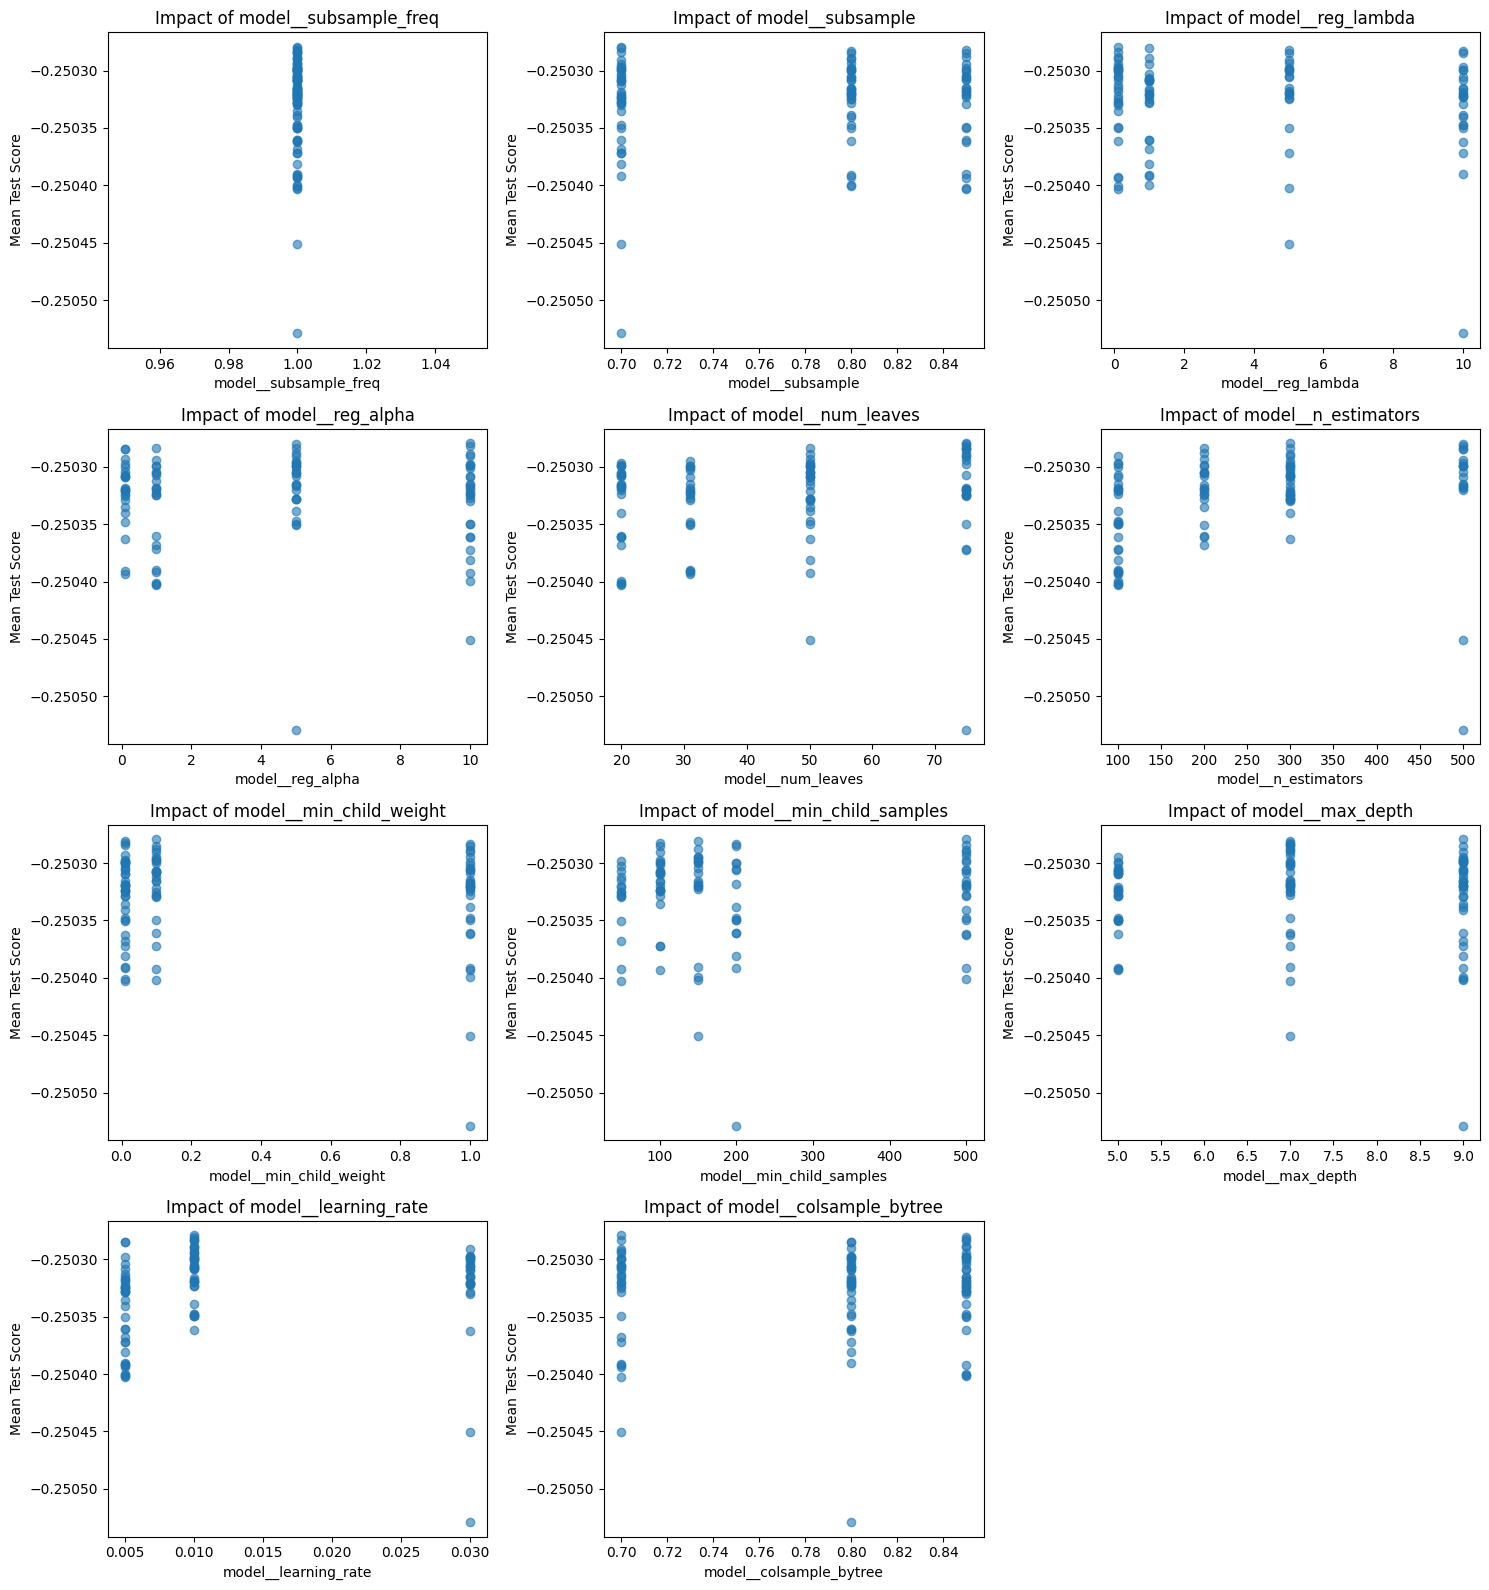

In [24]:
results_df = pd.DataFrame(random_search.cv_results_)

# Extract parameter columns
param_cols = [col for col in results_df.columns if col.startswith('param_')]

# Create clean dataframe
plot_df = results_df[param_cols + ['mean_test_score', 'std_test_score']].copy()
plot_df.columns = [col.replace('param_', '') for col in plot_df.columns]

# Parameters to plot
params = [col for col in plot_df.columns if col not in ['mean_test_score', 'std_test_score']]
n_params = len(params)

# Dynamic subplot grid
n_cols = 3
n_rows = math.ceil(n_params / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for idx, param in enumerate(params):
    ax = axes[idx]
    ax.scatter(plot_df[param], plot_df['mean_test_score'], alpha=0.6)
    ax.set_xlabel(param)
    ax.set_ylabel('Mean Test Score')
    ax.set_title(f'Impact of {param}')

# Remove unused subplots
for idx in range(len(params), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

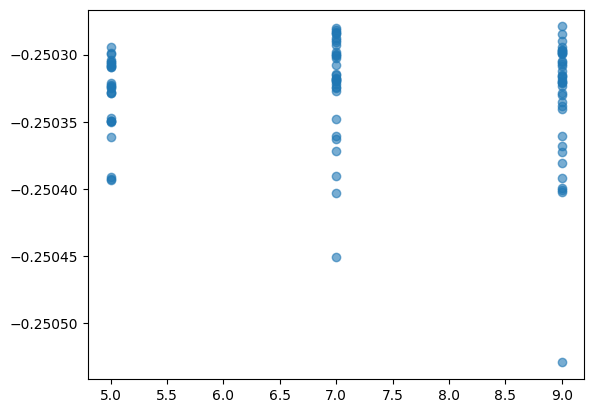

In [34]:
param = 'model__max_depth'

plt.scatter(plot_df[param], plot_df['mean_test_score'], alpha=0.6)

In [35]:
second_param_distributions = {
    'model__num_leaves': [20, 31, 75, 100],
    'model__learning_rate': [0.005, 0.01],
    'model__n_estimators': [200, 300, 500, 700],

    'model__min_child_samples': [100, 200, 500, 750],
    'model__min_child_weight': [0.1, 0.3, 0.5],
    'model__reg_alpha': [0.1, 0.5, 1, 2],
    'model__reg_lambda': [0.1, 0.5, 1, 3],

    'model__subsample': [0.75, 0.8, 0.85, 0.9],
    'model__subsample_freq': [1],
    'model__colsample_bytree': [0.6, 0.7, 0.8, 0.85, 0.9],

    'model__max_depth': [3, 5, 7, 9, 15],
}

In [36]:
second_random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=second_param_distributions,
    n_iter=100,
    scoring="neg_mean_squared_error",
    cv=cv,
    n_jobs=1,
    verbose=1,
    random_state=42
)

In [37]:
second_random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[LightGBM] [Info] Total Bins 66300
[LightGBM] [Info] Number of data points in the train set: 802537, number of used features: 260
[LightGBM] [Info] Start training from score 0.010611
[LightGBM] [Info] Total Bins 66300
[LightGBM] [Info] Number of data points in the train set: 1078492, number of used features: 260
[LightGBM] [Info] Start training from score 0.009381
[LightGBM] [Info] Total Bins 66300
[LightGBM] [Info] Number of data points in the train set: 1471273, number of used features: 260
[LightGBM] [Info] Start training from score 0.009066
[LightGBM] [Info] Total Bins 66300
[LightGBM] [Info] Number of data points in the train set: 802537, number of used features: 260
[LightGBM] [Info] Start training from score 0.010611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

RandomizedSearchCV(cv=ExpandingWindowCV(n_splits=3),
                   estimator=Pipeline(steps=[('model',
                                              LGBMRegressor(force_col_wise=True,
                                                            n_jobs=-1,
                                                            objective='regression',
                                                            random_state=42))]),
                   n_iter=100, n_jobs=1,
                   param_distributions={'model__colsample_bytree': [0.6, 0.7,
                                                                    0.8, 0.85,
                                                                    0.9],
                                        'model__learning_rate': [0.005, 0.01],
                                        'model__max_depth': [3, 5, 7, 9, 15],
                                        'model__min_child_samples': [100, 200,
                                                                     500, 750],
                                        'model__min_child_weight': [0.1, 0.3,
                                                                    0.5],
                                        'model__n_estimators': [200, 300, 500,
                                                                700],
                                        'model__num_leaves': [20, 31, 75, 100],
                                        'model__reg_alpha': [0.1, 0.5, 1, 2],
                                        'model__reg_lambda': [0.1, 0.5, 1, 3],
                                        'model__subsample': [0.75, 0.8, 0.85,
                                                             0.9],
                                        'model__subsample_freq': [1]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [38]:
with open("second_random_search.pkl", "wb") as f:
    pkl.dump(second_random_search, f)

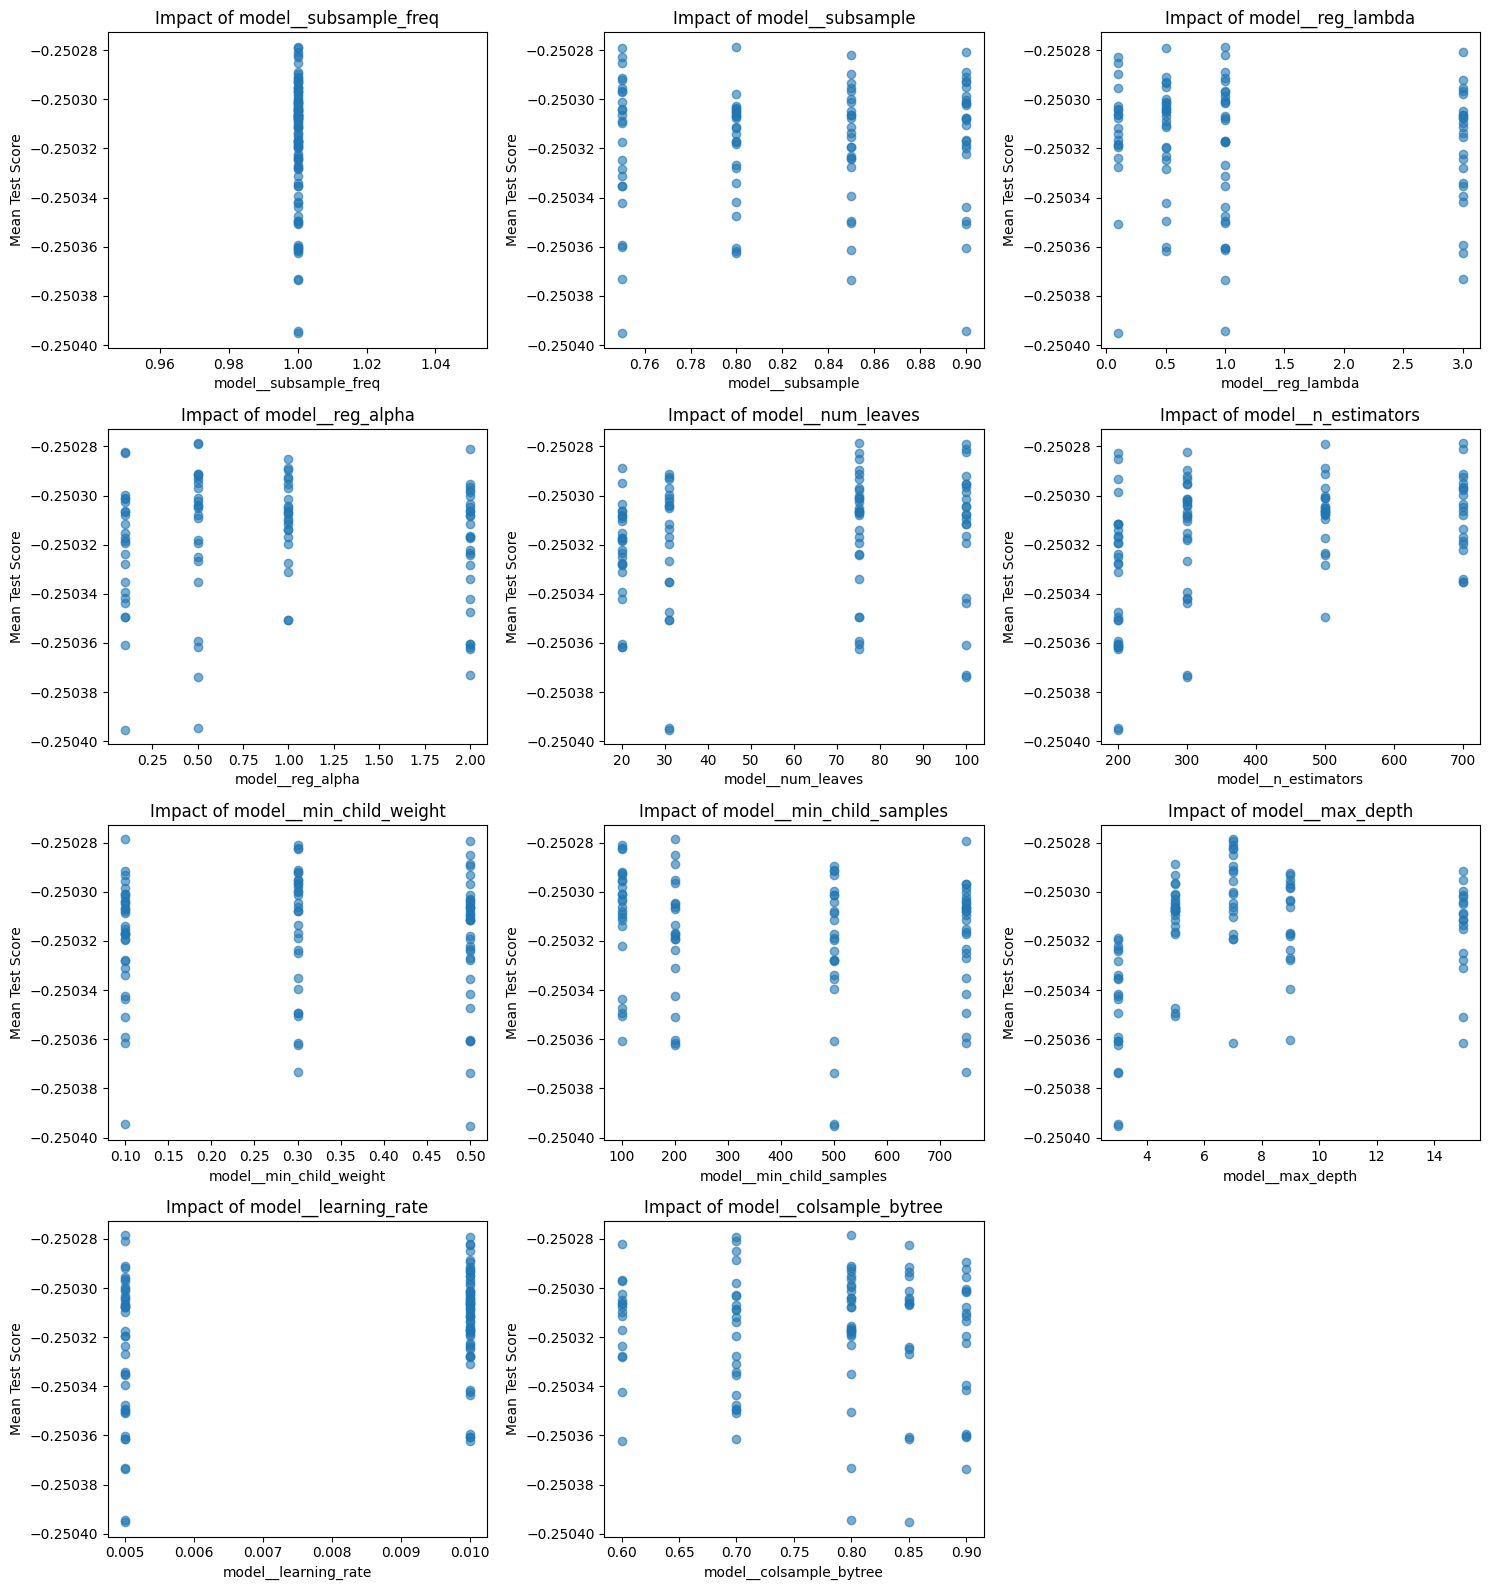

In [39]:
results_df = pd.DataFrame(second_random_search.cv_results_)

# Extract parameter columns
param_cols = [col for col in results_df.columns if col.startswith('param_')]

# Create clean dataframe
plot_df = results_df[param_cols + ['mean_test_score', 'std_test_score']].copy()
plot_df.columns = [col.replace('param_', '') for col in plot_df.columns]

# Parameters to plot
params = [col for col in plot_df.columns if col not in ['mean_test_score', 'std_test_score']]
n_params = len(params)

# Dynamic subplot grid
n_cols = 3
n_rows = math.ceil(n_params / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for idx, param in enumerate(params):
    ax = axes[idx]
    ax.scatter(plot_df[param], plot_df['mean_test_score'], alpha=0.6)
    ax.set_xlabel(param)
    ax.set_ylabel('Mean Test Score')
    ax.set_title(f'Impact of {param}')

# Remove unused subplots
for idx in range(len(params), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

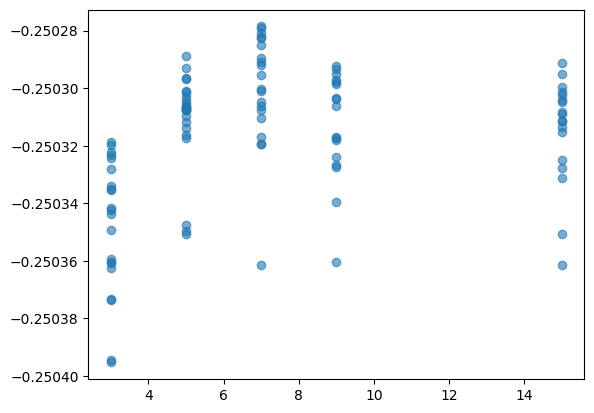

In [50]:
type_ = 'max_depth'
param = f'model__{type_}'

plt.scatter(plot_df[param], plot_df['mean_test_score'], alpha=0.6)

In [52]:
lgbm = Pipeline([
    # ('scaler', StandardScaler()),
    # ('pca', PCA(n_components=0.95)),
    ('model', LGBMRegressor(
        objective="regression",
        boosting_type="gbdt",
        random_state=42,
        n_jobs=-1,
        force_col_wise=True,
        num_leaves=75,
        learning_rate=0.01,
        n_estimators=700,
        min_child_samples=100,
        min_child_weight=0.1,
        reg_alpha=1,
        reg_lambda=0.5,
        subsample=0.8,
        subsample_freq=1,
        colsample_bytree=0.7,
        max_depth=7
    ))
])

In [53]:
%%time 
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 66300
[LightGBM] [Info] Number of data points in the train set: 1779489, number of used features: 260
[LightGBM] [Info] Start training from score 0.007649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Pipeline(steps=[('model',
                 LGBMRegressor(colsample_bytree=0.7, force_col_wise=True,
                               learning_rate=0.01, max_depth=7,
                               min_child_samples=100, min_child_weight=0.1,
                               n_estimators=700, n_jobs=-1, num_leaves=75,
                               objective='regression', random_state=42,
                               reg_alpha=1, reg_lambda=0.5, subsample=0.8,
                               subsample_freq=1))])

In [54]:
y_pred_lgbm = lgbm.predict(X_test)
df_test = df[df.index>=split_date][all_features + ["Ticker", "close_1d_ret", "close_1d_ret_hedged_normalised"]].replace([-np.inf, np.inf], np.nan).dropna()[["Ticker", "close_1d_ret", "close_1d_ret_hedged_normalised"]]
df_test['y_pred'] = y_pred_lgbm
df_test['lgbm_signal'] = df_test.groupby('Date')['y_pred'].transform(compute_signal)
lgbm_daily_returns = df_test.groupby('Date').apply(lambda x: (x['lgbm_signal']*x['close_1d_ret']).sum()/70)

<Axes: title={'center': 'Cumulative custom LGBM Strategy Return'}, xlabel='Date'>

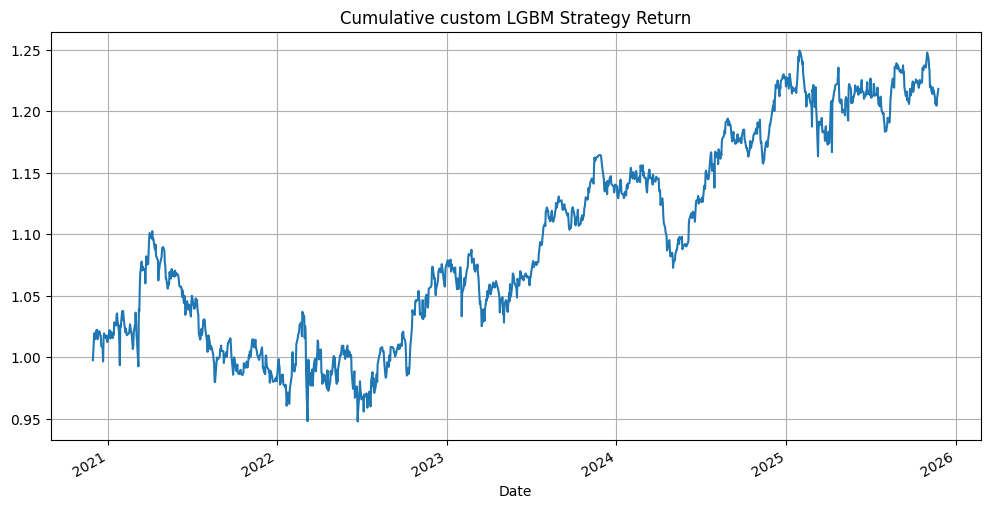

In [55]:
(1+lgbm_daily_returns*1e-4).cumprod().plot(figsize=(12,6), title='Cumulative custom LGBM Strategy Return', grid=True)

In [56]:
lgbm_daily_returns.mean()/lgbm_daily_returns.std()*np.sqrt(252)

np.float64(0.42879167624558295)

# LTR Strategies

## LambdaMART

In [73]:
from lightgbm import LGBMRanker

In [189]:
X = df[all_features + ["close_1d_ret_hedged_normalised"]].replace([-np.inf, np.inf], np.nan).dropna()[all_features]
y = df[all_features + ["close_1d_ret_hedged_normalised"]].replace([-np.inf, np.inf], np.nan).dropna()["close_1d_ret_hedged_normalised"]

split_date = X.index.unique().sort_values()[int(X.index.nunique()*0.8)]

X_train = X.loc[X.index<split_date]
X_test = X.loc[X.index>=split_date]
y_train = y.loc[y.index<split_date]
y_test = y.loc[y.index>=split_date]

In [190]:
y_train_ranks_long = y_train.groupby('Date').transform(lambda x: pd.qcut(x, q=10, labels=False))
y_test_ranks_long = y_test.groupby('Date').transform(lambda x: pd.qcut(x, q=10, labels=False))

y_train_ranks_short = (-y_train).groupby('Date').transform(lambda x: pd.qcut(x, q=10, labels=False))
y_test_ranks_short = (-y_test).groupby('Date').transform(lambda x: pd.qcut(x, q=10, labels=False))

In [191]:
# y_train_ranks_long = y_train.groupby('Date').transform(lambda x: x.rank(method='dense'))
# y_test_ranks_long = y_test.groupby('Date').transform(lambda x: x.rank(method='dense'))

# y_train_ranks_short = (-y_train).groupby('Date').transform(lambda x: x.rank(method='dense'))
# y_test_ranks_short = (-y_test).groupby('Date').transform(lambda x: x.rank(method='dense'))

In [192]:
train_groups = X_train.groupby('Date').size().values
test_groups = X_test.groupby('Date').size().values

In [193]:
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'boosting_type': "gbdt",
    'n_jobs': -1,
    'verbose': -1,
    'random_state': 42,
    # 'label_gain': list(range(500))
 }

In [194]:
model_long = LGBMRanker(**params)

In [195]:
model_short = LGBMRanker(**params)

In [196]:
model_long.fit(X_train, y_train_ranks_long, group=train_groups)

LGBMRanker(metric='ndcg', n_jobs=-1, objective='lambdarank', random_state=42,
           verbose=-1)

In [197]:
model_short.fit(X_train, y_train_ranks_short, group=train_groups)

LGBMRanker(metric='ndcg', n_jobs=-1, objective='lambdarank', random_state=42,
           verbose=-1)

In [198]:
test_scores_long = model_long.predict(X_test.values)
test_scores_short = model_short.predict(X_test.values)
X_test_scored = X_test.copy()
X_test_scored['score_long'] = test_scores_long
X_test_scored['score_short'] = test_scores_short
X_test_scored['actual_return'] = df[all_features + ["close_1d_ret_hedged_normalised", "close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()["close_1d_ret"].loc[split_date:]

/opt/python/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(
/opt/python/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


In [199]:
results_df = pd.DataFrame({
    'long_ret': X_test_scored.groupby('Date').apply(lambda x: x.sort_values('score_long', ascending=False).head(35)['actual_return'].mean()),
    'short_ret': X_test_scored.groupby('Date').apply(lambda x: x.sort_values('score_short', ascending=False).head(35)['actual_return'].mean())
})

In [200]:
results_df['ls_ret'] = results_df['long_ret'] - results_df['short_ret']

In [201]:
results_df['long_ret'].mean()/results_df['long_ret'].std()*np.sqrt(252)

np.float64(0.5298648281774795)

In [202]:
results_df['short_ret'].mean()/results_df['short_ret'].std()*np.sqrt(252)

np.float64(0.4517745552732112)

<Axes: title={'center': 'Cumulative custom LGBM Strategy Return'}, xlabel='Date'>

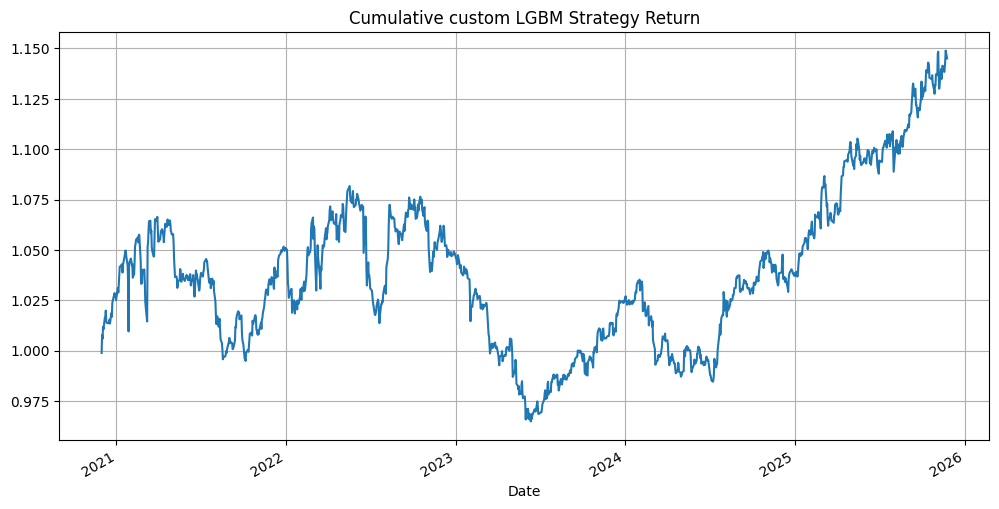

In [203]:
(1+results_df['ls_ret']*1e-4).cumprod().plot(figsize=(12,6), title='Cumulative custom LGBM Strategy Return', grid=True)

In [204]:
results_df['ls_ret'].mean()/results_df['ls_ret'].std()*np.sqrt(252)

np.float64(0.46502043727821446)

In [173]:
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import ndcg_score

In [226]:
param_distributions = {
    'num_leaves': [20, 31, 50, 75],
    'learning_rate': [0.005, 0.01, 0.03],
    'n_estimators': [100, 200, 300, 500],
    'min_child_samples': [50, 100, 150, 200, 500],
    'min_child_weight': [0.01, 0.1, 1],
    'reg_alpha': [0.1, 1, 5, 10],
    'reg_lambda': [0.1, 1, 5, 10],
    'subsample': [0.7, 0.8, 0.85],
    'subsample_freq': [1],
    'colsample_bytree': [0.7, 0.8, 0.85],
    'max_depth': [5, 7, 9],
}

In [227]:
cv = ExpandingWindowCV(n_splits=3)

In [228]:
param_list = list(ParameterSampler(param_distributions, n_iter=100, random_state=42))

In [229]:
results = []

for i, params in tqdm(enumerate(param_list)):
    cv_scores = []
    
    for train_idx, val_idx in cv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train_ranks_short.iloc[train_idx], y_train_ranks_short.iloc[val_idx]
        
        group_tr = X_tr.groupby('Date').size().values
        group_val = X_val.groupby('Date').size().values
        
        model = LGBMRanker(
            objective='lambdarank',
            metric='ndcg',
            boosting_type='gbdt',
            n_jobs=-1,
            random_state=42,
            **params
        )
        
        model.fit(
            X_tr, y_tr,
            group=group_tr,
        )
        
        y_pred_val = model.predict(X_val)
        sizes = group_val
        start = 0
        ndcgs = []
        for size in sizes:
            end = start + size
            ndcgs.append(ndcg_score([y_val.iloc[start:end]], [y_pred_val[start:end]],))
            start = end
        cv_scores.append(np.mean(ndcgs))
    
    mean_score = np.mean(cv_scores)
    std_score = np.std(cv_scores)
    
    results.append({**params, 'mean_test_score': mean_score, 'std_test_score': std_score})
    
    print(f"Iter {i+1}/100: NDCG = {mean_score:.4f} ± {std_score:.4f}")


1it [01:44, 104.87s/it]

Iter 1/100: NDCG = 0.8696 ± 0.0005


2it [02:18, 62.93s/it] 

Iter 2/100: NDCG = 0.8695 ± 0.0006


3it [04:01, 81.25s/it]

Iter 3/100: NDCG = 0.8695 ± 0.0006


4it [05:03, 73.78s/it]

Iter 4/100: NDCG = 0.8698 ± 0.0006


5it [05:38, 59.85s/it]

Iter 5/100: NDCG = 0.8695 ± 0.0004


6it [06:46, 62.61s/it]

Iter 6/100: NDCG = 0.8698 ± 0.0006


7it [08:01, 66.40s/it]

Iter 7/100: NDCG = 0.8696 ± 0.0006


8it [08:56, 62.90s/it]

Iter 8/100: NDCG = 0.8700 ± 0.0005


9it [10:38, 75.01s/it]

Iter 9/100: NDCG = 0.8696 ± 0.0005


10it [12:25, 84.96s/it]

Iter 10/100: NDCG = 0.8703 ± 0.0008


11it [12:58, 68.97s/it]

Iter 11/100: NDCG = 0.8700 ± 0.0007


12it [13:33, 58.74s/it]

Iter 12/100: NDCG = 0.8700 ± 0.0007


13it [14:07, 51.21s/it]

Iter 13/100: NDCG = 0.8698 ± 0.0006


14it [15:10, 54.93s/it]

Iter 14/100: NDCG = 0.8697 ± 0.0005


15it [16:06, 54.99s/it]

Iter 15/100: NDCG = 0.8697 ± 0.0005


16it [17:01, 55.26s/it]

Iter 16/100: NDCG = 0.8698 ± 0.0005


17it [18:17, 61.26s/it]

Iter 17/100: NDCG = 0.8702 ± 0.0007


18it [18:49, 52.52s/it]

Iter 18/100: NDCG = 0.8693 ± 0.0005


19it [19:23, 47.01s/it]

Iter 19/100: NDCG = 0.8695 ± 0.0005


20it [20:01, 44.28s/it]

Iter 20/100: NDCG = 0.8695 ± 0.0005


21it [21:06, 50.47s/it]

Iter 21/100: NDCG = 0.8700 ± 0.0006


22it [21:41, 45.91s/it]

Iter 22/100: NDCG = 0.8695 ± 0.0005


23it [23:25, 63.38s/it]

Iter 23/100: NDCG = 0.8700 ± 0.0007


24it [24:31, 64.16s/it]

Iter 24/100: NDCG = 0.8699 ± 0.0007


25it [26:33, 81.50s/it]

Iter 25/100: NDCG = 0.8701 ± 0.0007


26it [27:08, 67.48s/it]

Iter 26/100: NDCG = 0.8695 ± 0.0005


27it [28:15, 67.28s/it]

Iter 27/100: NDCG = 0.8699 ± 0.0007


28it [30:28, 86.94s/it]

Iter 28/100: NDCG = 0.8700 ± 0.0006


29it [31:36, 81.46s/it]

Iter 29/100: NDCG = 0.8697 ± 0.0005


30it [32:25, 71.72s/it]

Iter 30/100: NDCG = 0.8692 ± 0.0005


31it [33:31, 70.06s/it]

Iter 31/100: NDCG = 0.8698 ± 0.0006


32it [34:05, 59.11s/it]

Iter 32/100: NDCG = 0.8696 ± 0.0003


33it [34:41, 52.08s/it]

Iter 33/100: NDCG = 0.8698 ± 0.0005


34it [36:15, 64.64s/it]

Iter 34/100: NDCG = 0.8697 ± 0.0007


35it [36:46, 54.72s/it]

Iter 35/100: NDCG = 0.8692 ± 0.0007


36it [37:22, 48.95s/it]

Iter 36/100: NDCG = 0.8696 ± 0.0006


37it [37:56, 44.62s/it]

Iter 37/100: NDCG = 0.8697 ± 0.0005


38it [38:27, 40.51s/it]

Iter 38/100: NDCG = 0.8693 ± 0.0003


39it [39:26, 45.95s/it]

Iter 39/100: NDCG = 0.8696 ± 0.0005


40it [40:26, 50.19s/it]

Iter 40/100: NDCG = 0.8697 ± 0.0004


41it [41:58, 62.81s/it]

Iter 41/100: NDCG = 0.8697 ± 0.0006


42it [42:51, 59.97s/it]

Iter 42/100: NDCG = 0.8695 ± 0.0004


43it [43:27, 52.67s/it]

Iter 43/100: NDCG = 0.8694 ± 0.0005


44it [45:27, 73.01s/it]

Iter 44/100: NDCG = 0.8704 ± 0.0006


45it [46:29, 69.43s/it]

Iter 45/100: NDCG = 0.8703 ± 0.0007


46it [47:15, 62.51s/it]

Iter 46/100: NDCG = 0.8696 ± 0.0005


47it [48:20, 63.28s/it]

Iter 47/100: NDCG = 0.8697 ± 0.0005


48it [48:51, 53.70s/it]

Iter 48/100: NDCG = 0.8694 ± 0.0007


49it [50:24, 65.43s/it]

Iter 49/100: NDCG = 0.8695 ± 0.0005


50it [50:55, 55.14s/it]

Iter 50/100: NDCG = 0.8693 ± 0.0005


51it [51:28, 48.45s/it]

Iter 51/100: NDCG = 0.8695 ± 0.0005


52it [52:00, 43.44s/it]

Iter 52/100: NDCG = 0.8698 ± 0.0007


53it [54:01, 66.61s/it]

Iter 53/100: NDCG = 0.8700 ± 0.0005


54it [55:03, 65.27s/it]

Iter 54/100: NDCG = 0.8702 ± 0.0006


55it [56:04, 64.22s/it]

Iter 55/100: NDCG = 0.8697 ± 0.0006


56it [56:46, 57.44s/it]

Iter 56/100: NDCG = 0.8699 ± 0.0006


57it [57:18, 49.91s/it]

Iter 57/100: NDCG = 0.8696 ± 0.0005


58it [57:51, 44.84s/it]

Iter 58/100: NDCG = 0.8699 ± 0.0005


59it [58:53, 49.77s/it]

Iter 59/100: NDCG = 0.8701 ± 0.0006


60it [59:24, 44.08s/it]

Iter 60/100: NDCG = 0.8693 ± 0.0005


61it [1:00:37, 53.02s/it]

Iter 61/100: NDCG = 0.8695 ± 0.0006


62it [1:01:51, 59.23s/it]

Iter 62/100: NDCG = 0.8696 ± 0.0005


63it [1:03:50, 77.03s/it]

Iter 63/100: NDCG = 0.8701 ± 0.0008


64it [1:04:56, 73.68s/it]

Iter 64/100: NDCG = 0.8699 ± 0.0005


65it [1:05:43, 65.86s/it]

Iter 65/100: NDCG = 0.8698 ± 0.0005


66it [1:06:39, 62.76s/it]

Iter 66/100: NDCG = 0.8695 ± 0.0007


67it [1:08:00, 68.47s/it]

Iter 67/100: NDCG = 0.8696 ± 0.0004


68it [1:08:56, 64.63s/it]

Iter 68/100: NDCG = 0.8697 ± 0.0007


69it [1:09:35, 56.77s/it]

Iter 69/100: NDCG = 0.8694 ± 0.0006


70it [1:10:56, 64.28s/it]

Iter 70/100: NDCG = 0.8699 ± 0.0006


71it [1:12:30, 73.09s/it]

Iter 71/100: NDCG = 0.8696 ± 0.0004


72it [1:14:05, 79.65s/it]

Iter 72/100: NDCG = 0.8699 ± 0.0006


73it [1:15:12, 75.78s/it]

Iter 73/100: NDCG = 0.8700 ± 0.0006


74it [1:16:37, 78.52s/it]

Iter 74/100: NDCG = 0.8694 ± 0.0006


75it [1:17:32, 71.49s/it]

Iter 75/100: NDCG = 0.8692 ± 0.0005


76it [1:18:53, 74.46s/it]

Iter 76/100: NDCG = 0.8695 ± 0.0006


77it [1:20:47, 86.25s/it]

Iter 77/100: NDCG = 0.8701 ± 0.0006


78it [1:21:26, 72.12s/it]

Iter 78/100: NDCG = 0.8696 ± 0.0007


79it [1:22:11, 64.10s/it]

Iter 79/100: NDCG = 0.8696 ± 0.0003


80it [1:23:37, 70.57s/it]

Iter 80/100: NDCG = 0.8700 ± 0.0006


81it [1:24:59, 73.82s/it]

Iter 81/100: NDCG = 0.8697 ± 0.0005


82it [1:25:39, 63.87s/it]

Iter 82/100: NDCG = 0.8693 ± 0.0004


83it [1:26:50, 65.90s/it]

Iter 83/100: NDCG = 0.8695 ± 0.0006


84it [1:28:26, 75.13s/it]

Iter 84/100: NDCG = 0.8697 ± 0.0006


85it [1:29:33, 72.43s/it]

Iter 85/100: NDCG = 0.8698 ± 0.0005


86it [1:31:00, 76.85s/it]

Iter 86/100: NDCG = 0.8697 ± 0.0006


87it [1:32:07, 74.09s/it]

Iter 87/100: NDCG = 0.8700 ± 0.0004


88it [1:32:44, 62.79s/it]

Iter 88/100: NDCG = 0.8695 ± 0.0002


89it [1:35:09, 87.38s/it]

Iter 89/100: NDCG = 0.8701 ± 0.0005


90it [1:36:00, 76.71s/it]

Iter 90/100: NDCG = 0.8700 ± 0.0006


91it [1:37:16, 76.39s/it]

Iter 91/100: NDCG = 0.8693 ± 0.0006


92it [1:38:58, 83.93s/it]

Iter 92/100: NDCG = 0.8702 ± 0.0006


93it [1:40:52, 92.94s/it]

Iter 93/100: NDCG = 0.8698 ± 0.0006


94it [1:41:27, 75.68s/it]

Iter 94/100: NDCG = 0.8697 ± 0.0005


95it [1:42:34, 73.12s/it]

Iter 95/100: NDCG = 0.8695 ± 0.0005


96it [1:43:34, 69.11s/it]

Iter 96/100: NDCG = 0.8697 ± 0.0005


97it [1:44:27, 64.28s/it]

Iter 97/100: NDCG = 0.8694 ± 0.0006


98it [1:45:48, 69.31s/it]

Iter 98/100: NDCG = 0.8701 ± 0.0007


99it [1:46:41, 64.55s/it]

Iter 99/100: NDCG = 0.8694 ± 0.0006


100it [1:47:36, 64.57s/it]

Iter 100/100: NDCG = 0.8698 ± 0.0005


In [230]:
results_df = pd.DataFrame(results)

param_cols = [col for col in results_df.columns if col not in ['mean_test_score', 'std_test_score']]
plot_df = results_df[param_cols + ['mean_test_score', 'std_test_score']].copy()

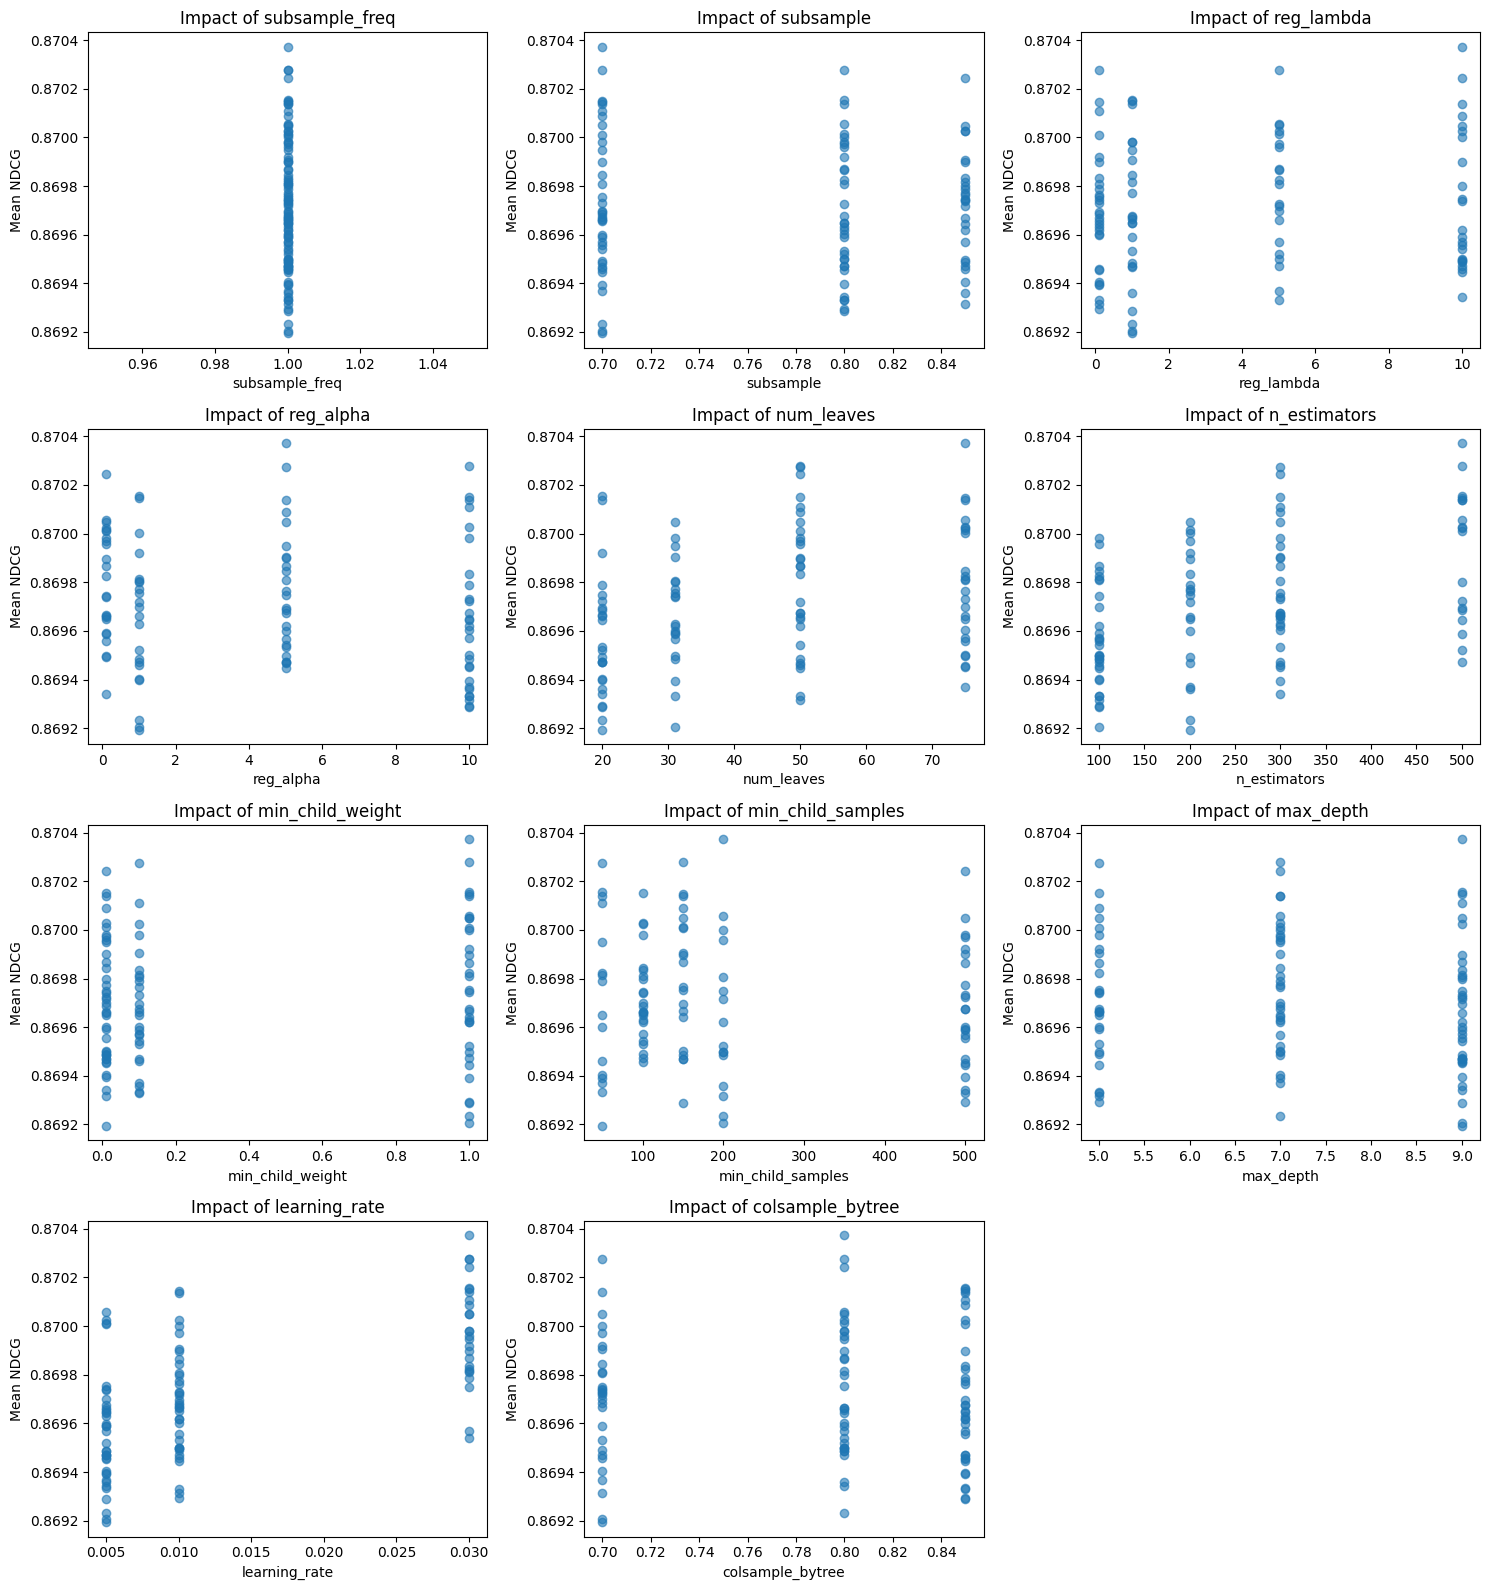

In [231]:
params = [col for col in plot_df.columns if col not in ['mean_test_score', 'std_test_score']]
n_params = len(params)
n_cols = 3
n_rows = math.ceil(n_params / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for idx, param in enumerate(params):
    ax = axes[idx]
    ax.scatter(plot_df[param], plot_df['mean_test_score'], alpha=0.6)
    ax.set_xlabel(param)
    ax.set_ylabel('Mean NDCG')
    ax.set_title(f'Impact of {param}')

for idx in range(len(params), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [ ]:
hyperparameters_short = {
    'num_leaves': 20,
    'learning_rate': 0.01,
    'n_estimators': 100,
    'min_child_samples': 100,
    'min_child_weight': 0.01,
    'reg_alpha': 1,
    'reg_lambda': 0.1,
    'subsample': 0.85,
    'subsample_freq': 1,
    'colsample_bytree': 0.85,
    'max_depth': 9,
}



# Here

In [224]:
hyperparameters_long = {
    'num_leaves': 20,
    'learning_rate': 0.01,
    'n_estimators': 100,
    'min_child_samples': 100,
    'min_child_weight': 0.01,
    'reg_alpha': 1,
    'reg_lambda': 0.1,
    'subsample': 0.85,
    'subsample_freq': 1,
    'colsample_bytree': 0.85,
    'max_depth': 9,
}

In [206]:
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'boosting_type': "gbdt",
    'n_jobs': -1,
    'verbose': -1,
    'random_state': 42,
    **hyperparameters
}

In [208]:
model_long = LGBMRanker(**params)

In [217]:
model_short = LGBMRanker(**params)

In [209]:
model_long.fit(X_train, y_train_ranks_long, group=train_groups)

LGBMRanker(colsample_bytree=0.85, learning_rate=0.01, max_depth=9,
           metric='ndcg', min_child_samples=100, min_child_weight=0.01,
           n_jobs=-1, num_leaves=20, objective='lambdarank', random_state=42,
           reg_alpha=1, reg_lambda=0.1, subsample=0.85, subsample_freq=1,
           verbose=-1)

In [218]:
model_short.fit(X_train, y_train_ranks_short, group=train_groups)

LGBMRanker(colsample_bytree=0.85, learning_rate=0.01, max_depth=9,
           metric='ndcg', min_child_samples=100, min_child_weight=0.01,
           n_jobs=-1, num_leaves=20, objective='lambdarank', random_state=42,
           reg_alpha=1, reg_lambda=0.1, subsample=0.85, subsample_freq=1,
           verbose=-1)

In [219]:
test_scores_long = model_long.predict(X_test.values)
test_scores_short = model_short.predict(X_test.values)
X_test_scored = X_test.copy()
X_test_scored['score_long'] = test_scores_long
X_test_scored['score_short'] = test_scores_short
X_test_scored['actual_return'] = df[all_features + ["close_1d_ret_hedged_normalised", "close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()["close_1d_ret"].loc[split_date:]

results_df = pd.DataFrame({
    'long_ret': X_test_scored.groupby('Date').apply(lambda x: x.sort_values('score_long', ascending=False).head(35)['actual_return'].mean()),
    'short_ret': X_test_scored.groupby('Date').apply(lambda x: x.sort_values('score_short', ascending=False).head(35)['actual_return'].mean())
})

results_df['ls_ret'] = results_df['long_ret'] - results_df['short_ret']

/opt/python/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(
/opt/python/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


In [220]:
results_df['long_ret'].mean()/results_df['long_ret'].std()*np.sqrt(252)

np.float64(0.5044825312738521)

In [221]:
results_df['short_ret'].mean()/results_df['short_ret'].std()*np.sqrt(252)

np.float64(0.44549177314458877)

<Axes: title={'center': 'Cumulative custom LGBM Strategy Return'}, xlabel='Date'>

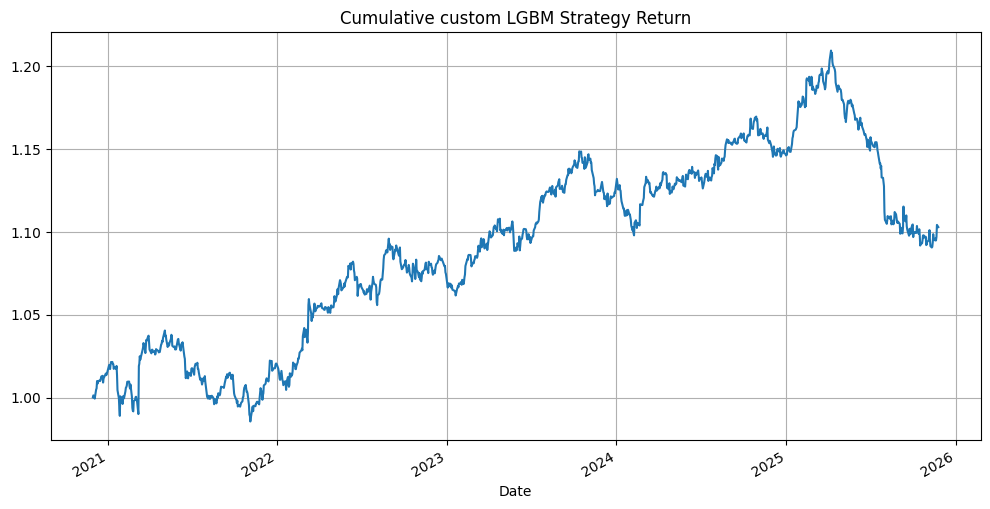

In [223]:
(1+results_df['ls_ret']*1e-4).cumprod().plot(figsize=(12,6), title='Cumulative custom LGBM Strategy Return', grid=True)

In [222]:
results_df['ls_ret'].mean()/results_df['ls_ret'].std()*np.sqrt(252)

np.float64(0.4612717837773984)